# Analysis of King County bike infractions for Central Seattle Greenways

#### Ethan C. Campbell

For questions, contact me at ethanchenbell@gmail.com.

In [1]:
%matplotlib inline
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from datetime import datetime, timedelta
from pytz import timezone
from skyfield import api, almanac 
import glob
import platform
import warnings
import sys
import progressbar

from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# choose root directory for data files
if platform.system() == 'Darwin':
    data_dir = '/Users/Ethan/Documents/Finances and records/2020-06-30 - Central Seattle Greenways/'
elif platform.system() == 'Linux':
    data_dir = '/dat1/ethancc/CSG/'

# Seattle Municipal Court summary chart

In [2]:
# load annual bike infraction data transcribed from Seattle Municipal Court online table (much of this data since purged from online)
seattle_summaries = pd.read_excel(data_dir + '2020-07-18 - Seattle Municipal Court bike violations (transcribed from online table).xlsx',
                                 index_col=0)
display(seattle_summaries)

,"Bicycle Helmet Required (9.10.010, 9.15.010)",Rider Rights/Duties Violation (11.44.020),R/W in Crosswalk (11.44.100),Riding on Road Rules Violation (11.44.040),No/Improper Lamps/Reflectors (11.44.160),Yield R/W on Public Path (11.44.120),No/Improper Hand Signals (11.44.140),Unsafe Pass on Right (11.44.080),No/Improper Brakes (11.44.200),Ride More Than 2 Abreast Road/Sidewalk (11.44.060),Clinging/Attaching to Vehicle (11.44.240),Control (11.44.260)
Year,,,,,,,,,,,,
2011,607,140,11,4,13,6,1,4,0,0,1,2
2012,306,124,11,3,14,1,2,2,0,0,1,1
2013,341,197,7,2,10,1,2,4,0,0,0,0
2014,168,108,4,2,4,4,1,1,0,0,0,1
2015,76,81,6,3,6,3,0,5,0,0,1,0
2016,41,71,4,2,6,1,1,2,0,0,0,0
2017,33,34,9,3,6,2,3,3,1,0,0,0
2018,46,78,5,6,7,3,4,5,0,1,0,0
2019,29,65,7,6,4,2,2,1,1,0,0,1


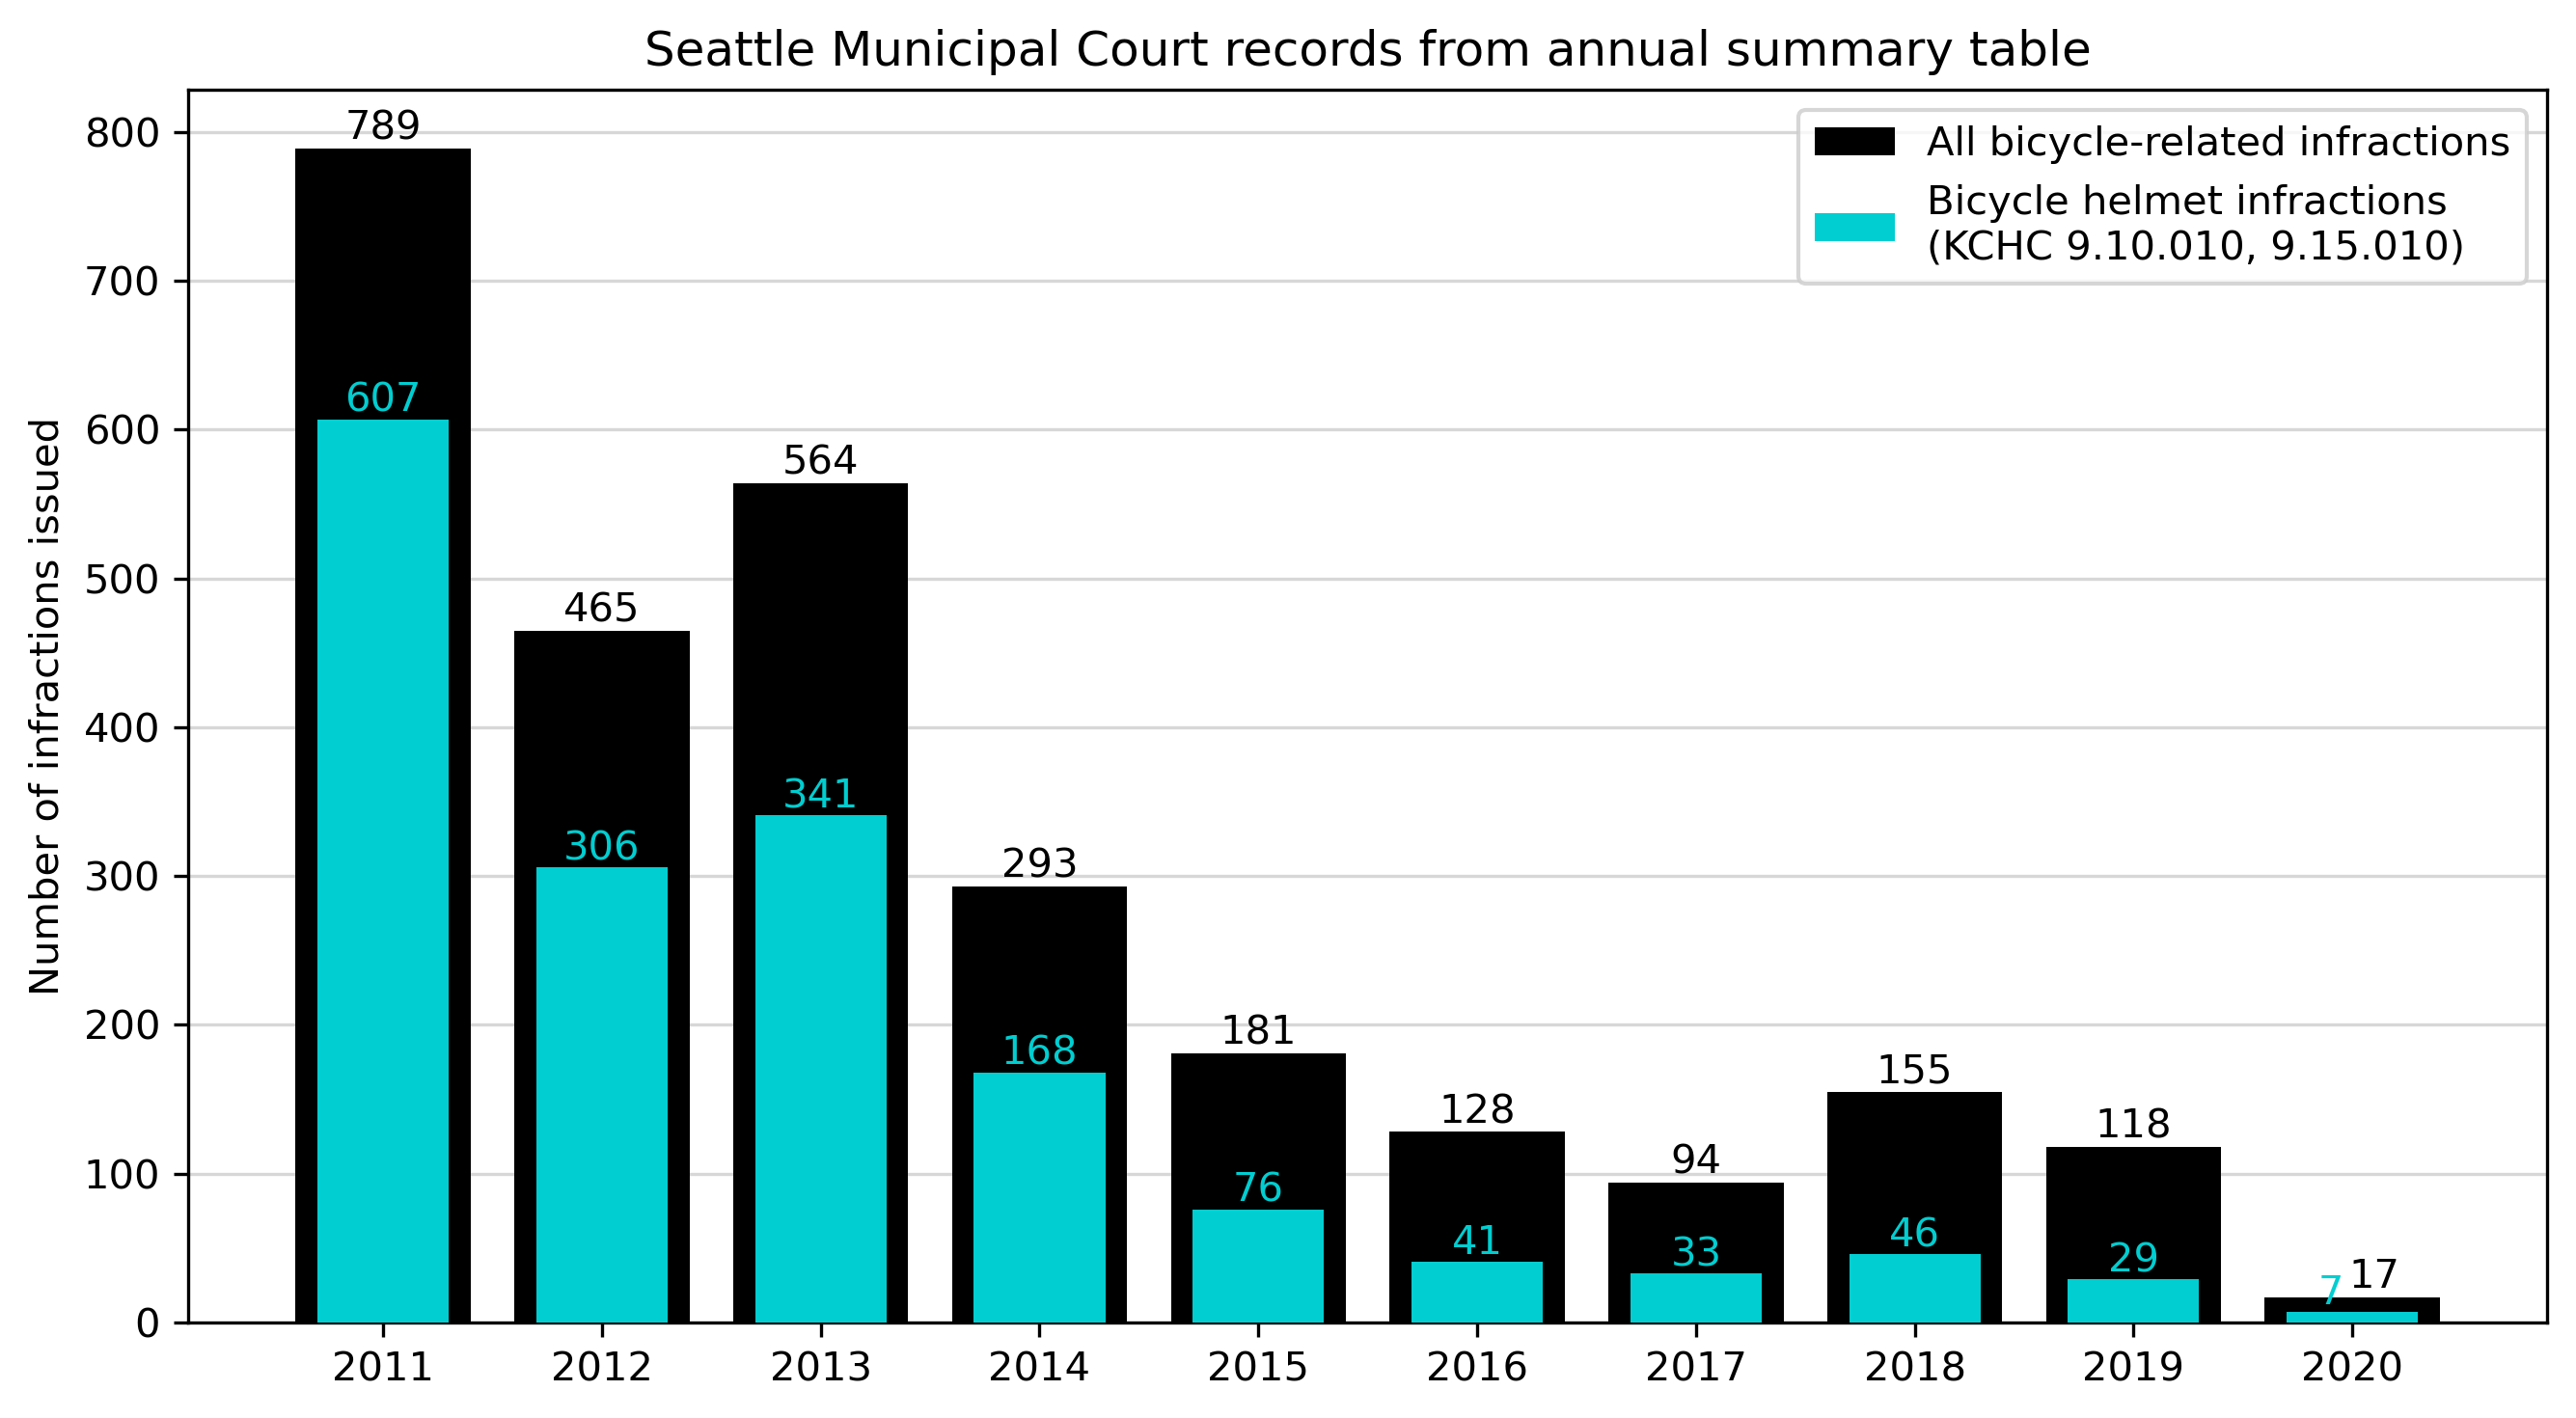

In [3]:
# plot annual data for selected Seattle bike infractions, shown differently

plt.figure(figsize=(9,5),facecolor='w')
if 'Total' in seattle_summaries: del seattle_summaries['Total']
seattle_summaries['Total'] = seattle_summaries.sum(axis=1)
x = seattle_summaries['Total'].index
y = seattle_summaries['Total'].values
plt.grid(axis='y',alpha=0.5,zorder=1)
plt.bar(x,y,color='k',zorder=2,label='All bicycle-related infractions')
for i, y_val in enumerate(y):
    if i == 9: label_offset = 0.1
    else:      label_offset = 0.0
    plt.text(x[i]+label_offset,y_val+6,str(y_val),c='k',fontweight='regular',horizontalalignment='center')

x = seattle_summaries['Bicycle Helmet Required (9.10.010, 9.15.010)'].index
y = seattle_summaries['Bicycle Helmet Required (9.10.010, 9.15.010)'].values
plt.bar(x,y,color='darkturquoise',width=0.6,zorder=3,
        label='Bicycle helmet infractions\n(KCHC 9.10.010, 9.15.010)')
for i, y_val in enumerate(y):
    if i == 9: label_offset = -0.1
    else:      label_offset = 0.0
    plt.text(x[i]+label_offset,y_val+5,str(y_val),c='darkturquoise',
             fontweight='regular',horizontalalignment='center')

plt.xticks(x)
plt.legend(frameon=True)
plt.ylabel('Number of infractions issued')
plt.title('Seattle Municipal Court records from annual summary table')
plt.tight_layout()

In [4]:
# assess fraction of total citations issued for helmet noncompliance by year
display(100 * seattle_summaries['Bicycle Helmet Required (9.10.010, 9.15.010)']/seattle_summaries['Total'])

Year
2011    76.932826
2012    65.806452
2013    60.460993
2014    57.337884
2015    41.988950
2016    32.031250
2017    35.106383
2018    29.677419
2019    24.576271
2020    41.176471
dtype: float64

# Load and process Seattle Municipal Court individual infraction records
### Batch 1 (without names)

In [5]:
# load Seattle Municipal Court infraction records from 2017-2020
seattle_mc_new = pd.read_excel(data_dir + '2020-07-16 - Seattle Municipal Court bicycle violations (2017-01-01 to 2020-06-30).xlsx',
                               index_col=None,parse_dates=[0,1])
seattle_mc_new['Defendant Race'] = seattle_mc_new['Defendant Race'].fillna('U')   # handle entries missing Defendant Race information
# display(seattle_mc_new)

# extract helmet violations into separate sheet
seattle_mc_new_helmet = seattle_mc_new[seattle_mc_new['Violation Description'] == 'BICYCLE HELMET REQUIRED'].copy()

#####

# load Seattle Municipal Court infraction records from 2003-2016 (incomplete due to purge schedule)
seattle_mc_old = pd.read_excel(data_dir + '2020-07-20 - Seattle Municipal Court bicycle violations (2003-01-01 to 2016-12-31).xlsx',
                               index_col=None,parse_dates=[0,1])
seattle_mc_old['Defendant Race'] = seattle_mc_old['Defendant Race'].fillna('U')   # handle entries missing Defendant Race information

# fix misnamed columns in records from 2003-2016
temp_officer_number = seattle_mc_old['Officer First Name'].copy()
temp_first_name = seattle_mc_old['Officer Middle Initial'].copy()
temp_middle_initial = seattle_mc_old['Officer Last Name'].copy()
temp_last_name = seattle_mc_old['Officer Number'].copy()
seattle_mc_old['Officer First Name'] = temp_first_name
seattle_mc_old['Officer Middle Initial'] = temp_middle_initial
seattle_mc_old['Officer Last Name'] = temp_last_name
seattle_mc_old['Officer Number'] = temp_officer_number
# display(seattle_mc_old)

# extract helmet violations into separate sheet
seattle_mc_old_helmet = seattle_mc_old[seattle_mc_old['Violation Description'] == 'BICYCLE HELMET REQUIRED'].copy()

#####

# merge old and new data
seattle_mc_combined = pd.concat([seattle_mc_old,seattle_mc_new]).copy().reset_index()
seattle_mc_combined_helmet = pd.concat([seattle_mc_old_helmet,seattle_mc_new_helmet]).copy().reset_index()

# merge date and time columns
seattle_mc_combined['Violation Datetime'] = seattle_mc_combined['Violation Date'] \
    + pd.to_timedelta(floor(seattle_mc_combined['Violation Time']/100),'h') \
    + pd.to_timedelta(seattle_mc_combined['Violation Time'] - 100*floor(seattle_mc_combined['Violation Time']/100),'m')
seattle_mc_combined_helmet['Violation Datetime'] = seattle_mc_combined_helmet['Violation Date'] \
    + pd.to_timedelta(floor(seattle_mc_combined_helmet['Violation Time']/100),'h') \
    + pd.to_timedelta(seattle_mc_combined_helmet['Violation Time'] - 100*floor(seattle_mc_combined_helmet['Violation Time']/100),'m')

# clean up officer badge numbers
seattle_mc_combined['Officer Number'] = seattle_mc_combined['Officer Number'].replace(9999,NaN)
seattle_mc_combined_helmet['Officer Number'] = seattle_mc_combined_helmet['Officer Number'].replace(9999,NaN)

# display data
display(seattle_mc_combined)

,index,Violation Date,Filing Date,Citation Number,Violation Code,Violation Description,Violation Time,Violation Location,Officer First Name,Officer Middle Initial,Officer Last Name,Officer Number,Defendant Race,Defendant Gender,Violation Datetime
0,0,2003-02-03,2003-02-05,10168275,11.44.020,RIGHTS AND DUTIES OF RIDERS,0,NaN,DEBORAH,D,BROOKS,4438.0,W,M,2003-02-03 00:00:00
1,1,2003-02-04,2003-02-05,10415746,11.44.020,RIGHTS AND DUTIES OF RIDERS,1055,NaN,ALAN,P,CARR,4253.0,U,M,2003-02-04 10:55:00
2,2,2003-03-02,2003-03-03,1065971,11.44.040,"BIKE, RIDE ON ROAD",225,NaN,CHAD,D,ZENTNER,6167.0,B,M,2003-03-02 02:25:00
3,3,2003-03-02,2003-03-03,1065971,11.44.040,"BIKE, RIDE ON ROAD",225,NaN,JON,A,ENGSTROM,6264.0,B,M,2003-03-02 02:25:00
4,4,2003-03-02,2003-03-03,1065971,11.44.160,"BIKE, LAMPS/REFLECTORS",225,NaN,CHAD,D,ZENTNER,6167.0,B,M,2003-03-02 02:25:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3417,442,2020-05-19,2020-06-23,12948137,SMC11.44.020,BIKE RIDER RIGHTS/DUTIES VIOLATION,1732,NaN,PRESTON,J,TURK,8468.0,W,M,2020-05-19 17:32:00
3418,443,2020-04-27,2020-06-23,12982637,KCHC9.10.010,BICYCLE HELMET REQUIRED,1537,NaN,ALEX,J,PRATT,7643.0,W,M,2020-04-27 15:37:00
3419,444,2020-04-27,2020-06-23,12982637,KCHC9.10.010,BICYCLE HELMET REQUIRED,1537,NaN,DAVID,S,WARNOCK,8389.0,W,M,2020-04-27 15:37:00
3420,445,2020-05-01,2020-06-23,12947249,KCHC9.10.010,BICYCLE HELMET REQUIRED,1708,NaN,SEAN,D,CULBERTSON,7662.0,W,M,2020-05-01 17:08:00


In [6]:
# remove duplicate entries (same defendant, same violation)
# but retain different violations (e.g. helmet and light violations) issued to same defendant under same citation number
# NOTE: this will impact analyses of officers, since it seems most (if not all) duplicates list two different officers
print('% of entire 2003-2020 record that are duplicates:',100*sum(seattle_mc_combined.duplicated(subset=['Citation Number','Violation Code']))/len(seattle_mc_combined))
print('Number of duplicates in entire 2003-2020 record:',sum(seattle_mc_combined.duplicated(subset=['Citation Number','Violation Code'])))
print('Number of duplicates of helmet infractions only:',sum(seattle_mc_combined_helmet.duplicated(subset=['Citation Number','Violation Code'])))

seattle_mc_combined = seattle_mc_combined.drop_duplicates(subset=['Citation Number','Violation Code'],keep='first')
seattle_mc_combined_helmet = seattle_mc_combined_helmet.drop_duplicates(subset=['Citation Number','Violation Code'],keep='first')
seattle_mc_old = seattle_mc_old.drop_duplicates(subset=['Citation Number','Violation Code'],keep='first')
seattle_mc_new = seattle_mc_new.drop_duplicates(subset=['Citation Number','Violation Code'],keep='first')
seattle_mc_old_helmet = seattle_mc_old_helmet.drop_duplicates(subset=['Citation Number','Violation Code'],keep='first')
seattle_mc_new_helmet = seattle_mc_new_helmet.drop_duplicates(subset=['Citation Number','Violation Code'],keep='first')

print('Number of records from 2003-2020 after de-duplication:',len(seattle_mc_combined))
print('Number of records from 2003-2017 after de-duplication:',len(seattle_mc_old))

# check for instances of a single defendant (single citation number) cited for multiple, different violations
print('% of entire 2003-2020 record that represent 2nd, 3rd, etc. violations:',
      100*sum(seattle_mc_combined.duplicated(subset=['Citation Number']))/len(seattle_mc_combined))

% of entire 2003-2020 record that are duplicates: 11.25073056691993
Number of duplicates in entire 2003-2020 record: 385
Number of duplicates of helmet infractions only: 233
Number of records from 2003-2020 after de-duplication: 3037
Number of records from 2003-2017 after de-duplication: 2653
% of entire 2003-2020 record that represent 2nd, 3rd, etc. violations: 5.959828778399737


In [7]:
# a handful of officers have assigned the vast majority of tickets with 'Unknown/other' race/ethnicity:
print('Number of tickets issued with ''Unknown/other'' race/ethnicity recorded, by SPD officer last name:')
display(seattle_mc_combined['Officer Last Name'][seattle_mc_combined['Defendant Race'] == 'U'].value_counts()[0:17])

print('Total number of tickets issued with ''Unknown/other'' race/ethnicity:',
      sum(seattle_mc_combined['Officer Last Name'][seattle_mc_combined['Defendant Race'] == 'U'].value_counts()))

# investigate outlier SPD officer, Brooke H. David (male, hired 09/2016), who almost never recorded race/ethnicity on tickets
print('\nNumber of tickets issued by SPD officer Brooke H. David, by recorded race/ethnicity:')
display(seattle_mc_combined['Defendant Race'][seattle_mc_combined['Officer First Name'] == 'BROOKE'].value_counts())

# for comparison...
print('\nNumber of tickets issued by SPD officer Glen A. Mulkey, by recorded race/ethnicity:')
display(seattle_mc_combined['Defendant Race'][seattle_mc_combined['Officer First Name'] == 'GLEN'].value_counts())

# delete his tickets and save to new data structures:
delete_brooke = True
if delete_brooke:
    smc_cleaned_combined \
       = seattle_mc_combined.drop(labels=seattle_mc_combined.index[seattle_mc_combined['Officer First Name'] == 'BROOKE'],axis=0)
    smc_cleaned_combined_helmet \
       = seattle_mc_combined_helmet.drop(labels=seattle_mc_combined_helmet.index[seattle_mc_combined_helmet['Officer First Name'] == 'BROOKE'],axis=0)
    smc_cleaned_new \
       = seattle_mc_new.drop(labels=seattle_mc_new.index[seattle_mc_new['Officer First Name'] == 'BROOKE'],axis=0)
    smc_cleaned_new_helmet \
       = seattle_mc_new_helmet.drop(labels=seattle_mc_new_helmet.index[seattle_mc_new_helmet['Officer First Name'] == 'BROOKE'],axis=0)
    smc_cleaned_old \
       = seattle_mc_old.drop(labels=seattle_mc_old.index[seattle_mc_old['Officer First Name'] == 'BROOKE'],axis=0)
    smc_cleaned_old_helmet \
       = seattle_mc_old_helmet.drop(labels=seattle_mc_old_helmet.index[seattle_mc_old_helmet['Officer First Name'] == 'BROOKE'],axis=0)

Number of tickets issued with Unknown/other race/ethnicity recorded, by SPD officer last name:


DAVID         66
MULKEY        54
ASHURST       17
SMITH         13
ELLIOTT        8
SHIREY         6
JONES          5
KEEFE          5
BROOKS         4
LANDERS        4
KANG           4
LANG           4
MILLER         4
DUNBAR         3
OMELANCHUK     3
BONESTEEL      3
STUART         3
Name: Officer Last Name, dtype: int64

Total number of tickets issued with Unknown/other race/ethnicity: 295

Number of tickets issued by SPD officer Brooke H. David, by recorded race/ethnicity:


U    66
W     9
Name: Defendant Race, dtype: int64


Number of tickets issued by SPD officer Glen A. Mulkey, by recorded race/ethnicity:


W    441
U     55
B     40
A     13
Name: Defendant Race, dtype: int64

# Load and process Seattle Municipal Court individual infraction records
### Batch 2 (with names)

In [8]:
# load Seattle Municipal Court infraction records from 2017-2020
smc_batch2_pt1 = pd.read_excel(data_dir + '2021-01-28 - Seattle Municipal Court bicycle violations (2003-01-01 to 2016-12-31).xlsx',
                               index_col=None,parse_dates=[12,13])
smc_batch2_pt2 = pd.read_excel(data_dir + '2021-02-16 - Seattle Municipal Court bicycle violations (2017-01-01 to 2021-02-16).xlsx',
                               index_col=None,parse_dates=[12,13])
smc_batch2 = pd.concat([smc_batch2_pt1,smc_batch2_pt2]).copy().reset_index().drop(columns='index')
smc_batch2.rename(columns={'Race Code':'Defendant Race','Gender Code':'Defendant Gender'},inplace=True)
smc_batch2['Defendant Race'] = smc_batch2['Defendant Race'].fillna('U')   # handle entries missing Defendant Race information

# merge date and time columns
smc_batch2['Violation Datetime'] = smc_batch2['Violation Date'] \
    + pd.to_timedelta(floor(smc_batch2['Violation Time']/100),'h') \
    + pd.to_timedelta(smc_batch2['Violation Time'] - 100*floor(smc_batch2['Violation Time']/100),'m')

# clean up officer badge numbers
smc_batch2['Officer Number'] = smc_batch2['Officer Number'].replace(9999,NaN)

# extract helmet violations into separate sheet
smc_batch2_helmet = smc_batch2[smc_batch2['Violation Description'] == 'BICYCLE HELMET REQUIRED'].copy()

In [9]:
# remove duplicate entries (same defendant, same violation)
# but retain different violations (e.g. helmet and light violations) issued to same defendant under same citation number
# NOTE: this will impact analyses of officers, since it seems most (if not all) duplicates list two different officers
print('BATCH 2 STATS:\n% of entire 2003-2020 record that are duplicates:',100*sum(smc_batch2.duplicated(subset=['Citation Number','Violation Code']))/len(smc_batch2))
print('Number of duplicates in entire 2003-2020 record:',sum(smc_batch2.duplicated(subset=['Citation Number','Violation Code'])))
print('Number of duplicates of helmet infractions only:',sum(smc_batch2_helmet.duplicated(subset=['Citation Number','Violation Code'])))

smc_batch2 = smc_batch2.drop_duplicates(subset=['Citation Number','Violation Code'],keep='first')
smc_batch2_helmet = smc_batch2_helmet.drop_duplicates(subset=['Citation Number','Violation Code'],keep='first')
print('Number of all records from 2003-2020 after de-duplication:',len(smc_batch2))
print('Number of helmet infraction records from 2003-2020 after de-duplication:',len(smc_batch2_helmet))

# display data
display(smc_batch2)

BATCH 2 STATS:
% of entire 2003-2020 record that are duplicates: 12.380952380952381
Number of duplicates in entire 2003-2020 record: 208
Number of duplicates of helmet infractions only: 72
Number of all records from 2003-2020 after de-duplication: 1472
Number of helmet infraction records from 2003-2020 after de-duplication: 206


,Citation Number,Case Number,Defendant First Name,Defendant Last Name,Defendant Race,Defendant Gender,City,State,Zip Code,Officer Number,...,Violation Time,Violation Code,Violation Description,Violation Location,Obligation Number,Obligation Amount Assessed,Obligation Amount Paid,Obligation Amount Outstanding,In Collection,Violation Datetime
0,10415746,202027811.0,IRVING,ARZETA,U,M,SEATTLE,WA,981223656,4253.0,...,1055,11.44.020,RIGHTS AND DUTIES OF RIDERS,NaN,19121954,67,57.0,0.0,No,2003-02-04 10:55:00
1,10416325,202033861.0,MACALISTER,LAWS,W,M,MT LAKE TERRACE,WA,98043,5585.0,...,1355,11.44.020,RIGHTS AND DUTIES OF RIDERS,NaN,19179230,67,67.0,0.0,No,2003-02-26 13:55:00
2,10420089,202038611.0,LISA,REYNOLDS,W,F,SEATTLE,WA,98122,6186.0,...,1527,11.44.080,"BIKE, PASS, RIGHT",NaN,19214469,67,0.0,0.0,No,2003-03-04 15:27:00
3,10108758,202071524.0,MORHAWI,HAILE,B,M,SEATTLE,WA,98118,6613.0,...,2045,11.44.040,"BIKE, RIDE ON ROAD",NaN,19481232,67,0.0,0.0,No,2003-05-01 20:45:00
5,10108759,202071532.0,MARKOS,MESHESHA,B,M,SEATTLE,WA,98118,5968.0,...,2045,11.44.040,"BIKE, RIDE ON ROAD",NaN,19481253,67,0.0,0.0,No,2003-05-01 20:45:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1674,XZ0843686,203966631.0,THOMAS,PARK,A,M,SEATTLE,WA,98112,8713.0,...,1545,SMC11.44.020,BIKE RIDER RIGHTS/DUTIES VIOLATION,300 BLOCK OF NICKERSON ST,42260400,87,0.0,0.0,No,2020-11-21 15:45:00
1675,12953186,203972208.0,STEPHEN,VANMATRE,W,M,SEATTLE,WA,98118,8767.0,...,1447,SMC11.44.100,BIKE R/W IN CROSSWALK,NaN,42328747,118,0.0,0.0,No,2020-11-21 14:47:00
1676,12978438,203970407.0,MATTHEW,SOLARO,W,M,SEATTLE,WA,98109,8308.0,...,2319,SMC11.44.040,BIKE RIDING ON ROAD RULES VIOL,NaN,42354054,165,0.0,165.0,No,2020-12-29 23:19:00
1678,1A0236841,203973157.0,MATTHEW,MCCLARNAND,W,M,SEATTLE,WA,98119,8689.0,...,1607,SMC11.44.020,BIKE RIDER RIGHTS/DUTIES VIOLATION,500 BLOCK OF 5 AVE,42340551,118,0.0,118.0,No,2021-02-02 16:07:00


In [10]:
# a handful of officers have assigned the vast majority of tickets with 'Unknown/other' race/ethnicity:
print('Number of tickets issued with ''Unknown/other'' race/ethnicity recorded, by SPD officer last name:')
display(smc_batch2['Officer Last Name'][smc_batch2['Defendant Race'] == 'U'].value_counts()[0:17])

print('Total number of tickets issued with ''Unknown/other'' race/ethnicity:',
      sum(smc_batch2['Officer Last Name'][smc_batch2['Defendant Race'] == 'U'].value_counts()))

# investigate outlier SPD officer, Brooke H. David (male, hired 09/2016), who almost never recorded race/ethnicity on tickets
print('\nNumber of tickets issued by SPD officer Brooke H. David, by recorded race/ethnicity:')
display(smc_batch2['Defendant Race'][smc_batch2['Officer First Name'] == 'BROOKE'].value_counts())

# delete his tickets and save to new data structures:
delete_brooke = True
if delete_brooke:
    smc_batch2 \
       = smc_batch2.drop(labels=smc_batch2.index[smc_batch2['Officer First Name'] == 'BROOKE'],axis=0)
    smc_batch2_helmet \
       = smc_batch2_helmet.drop(labels=smc_batch2_helmet.index[smc_batch2_helmet['Officer First Name'] == 'BROOKE'],axis=0)

Number of tickets issued with Unknown/other race/ethnicity recorded, by SPD officer last name:


DAVID         66
MULKEY         9
SHIREY         5
SMITH          5
KANG           4
BROOKS         3
DUNBAR         3
KEEFE          3
BONESTEEL      3
RICHARDSON     2
MAHAR          2
STUART         2
UNGER          2
OWINGS         2
CAREY          2
PECORE         2
STEVENS        2
Name: Officer Last Name, dtype: int64

Total number of tickets issued with Unknown/other race/ethnicity: 185

Number of tickets issued by SPD officer Brooke H. David, by recorded race/ethnicity:


U    66
W     9
Name: Defendant Race, dtype: int64

In [11]:
# preliminary assessment of completeness of Batch 2 data:
# plt.hist(seattle_mc_combined['Violation Datetime'].dt.year,bins=arange(2003,2022),color='k')
# plt.hist(smc_batch2['Violation Datetime'].dt.year,bins=arange(2003,2022),color='0.8')
# plt.hist(smc_batch2_helmet['Violation Datetime'].dt.year,bins=arange(2003,2022),color='0.5')

print('Approx. % of all Batch 1 records included in Batch 2 (ignoring 2020/2021 mismatch):',100*len(smc_batch2)/len(seattle_mc_combined))
print('Approx. % of all Batch 1 helmet records included in Batch 2 (ignoring 2020/2021 mismatch):',100*len(smc_batch2_helmet)/len(seattle_mc_combined_helmet))
print('\nDefendant race breakdown for all 2003-2021 records in Batch 2:')
smc_batch2['Defendant Race'].value_counts() / sum(smc_batch2['Defendant Race'].value_counts())

Approx. % of all Batch 1 records included in Batch 2 (ignoring 2020/2021 mismatch): 45.9993414553836
Approx. % of all Batch 1 helmet records included in Batch 2 (ignoring 2020/2021 mismatch): 12.290167865707435

Defendant race breakdown for all 2003-2021 records in Batch 2:


W    0.748747
B    0.133858
U    0.085183
A    0.025054
I    0.007158
Name: Defendant Race, dtype: float64

# Disaggregation of non-Hispanic/Latino and Hispanic/Latino defendants

For more info, see::
* https://pypi.org/project/ethnicolr/
* https://github.com/appeler/ethnicolr
* https://arxiv.org/pdf/1805.02109.pdf
* NC model: https://github.com/appeler/nc_race_ethnicity

In [12]:
# export data with defendant names
export_names = True
if export_names:
    names = smc_batch2[['Defendant First Name','Defendant Last Name']]
    names.to_csv(data_dir + 'seattle_municipal_court_batch2_names.csv')
    
# read imputed name classifications
last_name_census_match = pd.read_csv(data_dir + 'seattle_municipal_court_batch2_names_last_name_census_match.csv')
last_name_census_pred = pd.read_csv(data_dir + 'seattle_municipal_court_batch2_names_last_name_census_pred.csv')
full_name_NC_pred = pd.read_csv(data_dir + 'seattle_municipal_court_batch2_names_full_name_NC_pred.csv')
full_name_FL_pred = pd.read_csv(data_dir + 'seattle_municipal_court_batch2_names_full_name_FL_pred.csv')

In [13]:
# compare imputed race/ethnicity distributions from different methods:

# defendant race % in original SMC data (Batch 2)
print('Original SMC Batch 2 data (%):')
orig_dist = smc_batch2['Defendant Race'].value_counts()
orig_dist = 100 * orig_dist / orig_dist.sum()
display(orig_dist)

# defendant race %, if Unknown/Other category dropped from SMC data (Batch 2)
print('\nSMC Batch 2 data if Unknown/Other category were dropped, and distribution recalculated (%):')
redist = orig_dist.drop(index='U')
redist = 100 * redist / redist.sum()
display(redist)

# METHOD 1: 2010 Census last name matches
#           note: calculated average distribution, then dropped "two or more races" category and recalculated distribution
print('\nMETHOD 1: 2010 Census last name matches (%):')
census_match_redist = last_name_census_match[['pctwhite','pctblack','pctapi','pctaian','pcthispanic']].mean(axis=0)
census_match_redist = 100 * census_match_redist / census_match_redist.sum()
census_match_redist.rename({'pctwhite':'W','pctblack':'B','pctapi':'A','pctaian':'I','pcthispanic':'H'},inplace=True)
census_match_redist = census_match_redist.reindex(index=['W','H','B','A','I'])
display(census_match_redist)

hispanic_estimate_1 = 100 * census_match_redist['H'] / (census_match_redist['W'] + census_match_redist['H'])
print('\nMETHOD 1 estimate for Hispanic % of White category:',hispanic_estimate_1)

# defendant race %, if Unknown/Other and Native American/Alaska Native categories dropped from SMC data (Batch 2)
print('\nSMC Batch 2 data if Unknown/Other and Native American/Alaska Native categories were dropped, and distribution recalculated (%):')
redist = orig_dist.drop(index=['U','I'])
redist = 100 * redist / redist.sum()
display(redist)

# METHOD 2: 2010 Census last name prediction model
print('\nMETHOD 2: 2010 Census last name prediction model (%):')
census_pred_redist = last_name_census_pred[['api','black','hispanic','white']].mean(axis=0)
census_pred_redist = 100 * census_pred_redist / census_pred_redist.sum()
census_pred_redist.rename({'api':'A','black':'B','hispanic':'H','white':'W'},inplace=True)
census_pred_redist = census_pred_redist.reindex(index=['W','H','B','A'])
display(census_pred_redist)

hispanic_estimate_2 = 100 * census_pred_redist['H'] / (census_pred_redist['W'] + census_pred_redist['H'])
print('\nMETHOD 2 estimate for Hispanic % of White category:',hispanic_estimate_2)

# METHOD 3: Florida voter registration data model prediction
print('\nMETHOD 3: Florida full name prediction model (%):')
fl_pred_redist = full_name_FL_pred[['asian','hispanic','nh_black','nh_white']].mean(axis=0)
fl_pred_redist = 100 * fl_pred_redist / fl_pred_redist.sum()
fl_pred_redist.rename({'asian':'A','nh_black':'B','hispanic':'H','nh_white':'W'},inplace=True)
fl_pred_redist = fl_pred_redist.reindex(index=['W','H','B','A'])
display(fl_pred_redist)

hispanic_estimate_3 = 100 * fl_pred_redist['H'] / (fl_pred_redist['W'] + fl_pred_redist['H'])
print('\nMETHOD 3 estimate for Hispanic % of White category:',hispanic_estimate_3)

print('\nMETHODS 1-3 average estimate for Hispanic % of White category:',
      mean([hispanic_estimate_1,hispanic_estimate_2,hispanic_estimate_3]))

# METHOD 4: North Carolina voter registration data model prediction
#           note: results vary drastically from known distribution, so discarding this model
print('\nMETHOD 4: North Carolina full name prediction model (%):')
full_name_NC_pred_dropped = full_name_NC_pred.drop(columns=['Unnamed: 0','Unnamed: 0.1','Defendant First Name',
                                                            'Defendant Last Name','race'])
display(full_name_NC_pred_dropped.mean(axis=0).sort_values())

Original SMC Batch 2 data (%):


W    74.874732
B    13.385827
U     8.518253
A     2.505369
I     0.715820
Name: Defendant Race, dtype: float64


SMC Batch 2 data if Unknown/Other category were dropped, and distribution recalculated (%):


W    81.846635
B    14.632238
A     2.738654
I     0.782473
Name: Defendant Race, dtype: float64


METHOD 1: 2010 Census last name matches (%):


W    73.548261
H     7.653135
B    14.387101
A     3.683168
I     0.728336
dtype: float64


METHOD 1 estimate for Hispanic % of White category: 9.424881418353529

SMC Batch 2 data if Unknown/Other and Native American/Alaska Native categories were dropped, and distribution recalculated (%):


W    82.492114
B    14.747634
A     2.760252
Name: Defendant Race, dtype: float64


METHOD 2: 2010 Census last name prediction model (%):


W    73.644321
H     9.213929
B    13.342225
A     3.799524
dtype: float64


METHOD 2 estimate for Hispanic % of White category: 11.120110897747638

METHOD 3: Florida full name prediction model (%):


W    78.206096
H     6.834126
B    11.924366
A     3.035412
dtype: float64


METHOD 3 estimate for Hispanic % of White category: 8.036345175624371

METHODS 1-3 average estimate for Hispanic % of White category: 9.527112497241845

METHOD 4: North Carolina full name prediction model (%):


HL+A    0.000306
HL+I    0.000701
HL+B    0.017902
HL+M    0.020229
NL+I    0.065668
HL+O    0.065798
NL+A    0.076282
HL+W    0.086897
NL+M    0.102017
NL+O    0.151389
NL+B    0.179898
NL+W    0.232911
dtype: float64

# Preliminary analysis of defendant zip codes

In [14]:
cities = smc_batch2['City'].values
zipcodes = smc_batch2['Zip Code'].apply(lambda x: str(x)[0:5]).values
for z_idx, zipcode in enumerate(zipcodes):
    if zipcode == 'nan': zipcodes[z_idx] == 'No zip code'
    else: zipcodes[z_idx] = int(zipcode)
        
pd.Series(cities).value_counts()[0:15]

SEATTLE        998
SHORELINE       26
RENTON          18
KENT            16
BURIEN          13
TACOMA          11
FEDERAL WAY     11
SEATAC           9
SPOKANE          9
AUBURN           9
BELLINGHAM       8
EDMONDS          8
BELLEVUE         8
TUKWILA          8
REDMOND          7
dtype: int64

In [15]:
pd.Series(zipcodes[cities == 'SEATTLE']).value_counts()

98104    102
98122     99
98103     78
98105     65
98144     49
98108     44
98118     43
98107     41
98102     40
98121     37
98109     37
98101     35
98112     35
98115     33
98117     31
98133     30
98106     24
98119     21
98125     16
98116     16
98178     13
98146     12
98134     11
98126     10
98136      9
98168      8
98199      8
nan        7
98177      6
98123      3
98275      2
98187      2
98022      2
98270      2
98155      2
98114      2
98012      1
98         1
98145      1
90102      1
98149      1
98407      1
98142      1
98176      1
9810       1
8144       1
98124      1
98370      1
98111      1
981        1
99999      1
98204      1
98203      1
99354      1
98198      1
98188      1
98055      1
98165      1
98043      1
dtype: int64

# Census data loading function

In [16]:
# define function to load US Census Bureau American Community Survey (ACS) demographic data

# data obtained from, e.g. for Seattle: https://data.census.gov/cedsci/table?q=Seattle%20city,%20Washington&g=1600000US5363000&hidePreview=true&tid=ACSDP5Y2018.DP05&table=DP05
# note this grouping of racial categories is made as a guess as to how a police officer would most likely perceive and categorize a subject:
#    - 'Black' includes those listed in 'Two or more races' as 'Black and White' and 'Black and Native American'
#    - 'Asian_PacIs' includes those listed in 'Two or more races' as 'Asian and White'
#    - 'NativeAm_AlaskanNat' includes those listed in 'Two or more races' as 'Native American and White'

def load_census(city_abbrev,span,years=arange(2010,2018+1)):
    """
    Args:
        city_abbrev: e.g. 'Seattle', 'Federal_Way', etc.
        span: ACS span in years (1 or 5)
        years: ACS year or years to load (exact year for ACS 1-year or final year for ACS 5-year, e.g. 2010 for 2006-2010)
    """
    root_dir = data_dir + '2020-07-18 - US Census Bureau American Community Survey (ACS) data/'
    city_dir = '{0}_ACS_{1}_yr/'.format(city_abbrev,span)
    if type(years) == int: years = [years]
    census_data = pd.DataFrame(index=years,columns=['Total_population','Asian_PacIs','Black','NativeAm_AlaskanNat','White','Other','White_HispLat','White_Non_HispLat'])
    for year in years:
        filename_wildcard = 'ACSDP{0}Y{1}.DP05_data*.csv'.format(span,year)
        filename = glob.glob(root_dir + city_dir + filename_wildcard)[0]
        raw_census_data = pd.read_csv(filename,header=1)
        if 'Percent!!RACE!!One race!!Asian' in raw_census_data.columns:
            header = 'Percent!!RACE!!'
            lat_header = 'Percent!!HISPANIC OR LATINO AND RACE!!'
        else:
            header = 'Percent Estimate!!RACE!!Total population!!'
            lat_header = 'Percent Estimate!!HISPANIC OR LATINO AND RACE!!Total population!!'
        tot_pop = raw_census_data['Estimate!!RACE!!Total population'].values[0]
        api_percent = raw_census_data[header + 'One race!!Asian'].values[0] + \
                      raw_census_data[header + 'One race!!Native Hawaiian and Other Pacific Islander'].values[0] + \
                      raw_census_data[header + 'Two or more races!!White and Asian'].values[0]
        black_percent = raw_census_data[header + 'One race!!Black or African American'].values[0] + \
                        raw_census_data[header + 'Two or more races!!White and Black or African American'].values[0] + \
                        raw_census_data[header + 'Two or more races!!Black or African American and American Indian and Alaska Native'].values[0]
        natam_percent = raw_census_data[header + 'One race!!American Indian and Alaska Native'].values[0] + \
                        raw_census_data[header + 'Two or more races!!White and American Indian and Alaska Native'].values[0]
        white_percent = raw_census_data[header + 'One race!!White'].values[0]
        try:             white_lat_percent = raw_census_data[lat_header + 'Hispanic or Latino (of any race)'].values[0]
        except KeyError: white_lat_percent = raw_census_data[lat_header + 'Total population!!Hispanic or Latino (of any race)'].values[0]
        white_nonlat_percent = white_percent - white_lat_percent
        other_percent = 100.0 - api_percent - black_percent - natam_percent - white_percent
        if other_percent < 0.0: print('Uh oh... summed total of racial percentages is greater than 100%')
        census_data.loc[year] = {'Total_population':tot_pop,'Asian_PacIs':api_percent,'Black':black_percent,
                                 'NativeAm_AlaskanNat':natam_percent,'White':white_percent,'Other':other_percent,
                                 'White_HispLat':white_lat_percent,'White_Non_HispLat':white_nonlat_percent}
    if span == 5: census_data['5_yr_period'] = ['{0}-{1}'.format(yr-4,yr) for yr in census_data.index]
    return census_data

# 2013 SDOT/EMC survey data

In [17]:
# load racial statistics from SDOT 2013 Bicycle Participation Phone Survey
# data information and access:
#     - https://www.seattle.gov/transportation/projects-and-programs/programs/bike-program/bike-data
#     - https://www.seattle.gov/Documents/Departments/SDOT/BikeProgram/13-5004bikesdotcrosstab.pdf

sdot_survey = pd.read_excel(data_dir + '2020-07-18 - SDOT 2013 Bicycle Participation Phone Survey - racial statistics.xlsx',
                            index_col=0)
sdot_survey

,Percent riding a few times per year,Number riding a few times per year,Percent riding a few times per month or more,Number riding a few times per month or more,Average percent
Race/ethnicity,,,,,
All,100,69.00,100,110.0,100.0
Black,5,3.45,4,4.4,4.5
White,72,49.68,80,88.0,76.0
Hispanic,2,1.38,2,2.2,2.0
Asian,18,12.42,11,12.1,14.5
Other,2,1.38,4,4.4,3.0
Refuse,1,0.69,0,0.0,0.5
White_Hispanic,74,51.06,82,90.2,78.0
Residual,3,2.07,3,3.3,3.0


# Historical record of bike infractions by year

**Source: Seattle Times, "The cop and the courier: Seattle’s top-ticketing officer, and its most-ticketed cyclist" by Gene Balk (July 15, 2015)**

In [18]:
from IPython.display import Image
display(Image(url='https://static.seattletimes.com/wp-content/uploads/2015/07/aed058d2-2b4d-11e5-bef9-f00a1a6eacb9-1560x1133.jpg',
              width=500,height=300))

seattle_hist_all = pd.Series(index=arange(1990,2015),
                             data=[143,149,172,125,161,157,142,179,101,141,150,152,159,
                                   197,195,215,478,289,577,525,656,733,405,501,270])

# add more recent infraction totals from Seattle Municipal Court summary table online (since deleted, but transcribed above)
for year in seattle_summaries.index:
    seattle_hist_all[int(year)] = seattle_summaries['Total'][year]

# 'Veil of darkness' test

Resources:
* https://www.nature.com/articles/s41562-020-0858-1#Sec8
* https://www.tandfonline.com/doi/abs/10.1198/016214506000000168
* https://rhodesmill.org/skyfield/
* https://rhodesmill.org/skyfield/almanac.html#sunrise-and-sunset

In [77]:
# set up Skyfield/Pytz package parameters
ts = api.load.timescale()
eph = api.load('de421.bsp')
seattle = api.wgs84.latlon(47.60841929621059,-122.34052784957409)   # Pike Place Market :)
pacific = timezone('US/Pacific')
day_almanac = almanac.dark_twilight_day(eph,seattle)

# example Skyfield/Pytz timezone conversions
sample_dt_local = datetime(2014, 1, 16, 1, 32, 9)
sample_dt_pt = pacific.localize(sample_dt_local)
sample_dt_for_skyfield = ts.from_datetime(sample_dt_pt)
no_diff = sample_dt_for_skyfield.astimezone(pacific) - \
          pacific.localize(datetime(2014, 1, 16, 1, 32, 9))  # convert back

# example of twilight calculation
day_start = ts.from_datetime(pacific.localize(datetime(2021,12,15,0)))
day_end = ts.from_datetime(pacific.localize(datetime(2021,12,15,23,59,59)))
day_almanac = almanac.dark_twilight_day(eph,seattle)
day_almanac_times, _ = almanac.find_discrete(day_start,day_end,day_almanac)
day_almanac_times[2].astimezone(pacific)  # civil dawn (start of civil twilight)
day_almanac_times[3].astimezone(pacific)  # sunrise (end of civil twilight)
day_almanac_times[4].astimezone(pacific)  # sunset (start of civil twilight)
day_almanac_times[5].astimezone(pacific)  # civil dusk (end of civil twilight)

# calculate almanac times for every SMC record
process_almanac_times = False
if process_almanac_times:
    for idx in progressbar.progressbar(smc_cleaned_combined.index.values,redirect_stdout=True):
        infraction_dt = smc_cleaned_combined.loc[idx,'Violation Datetime']
        day_start = ts.from_datetime(pacific.localize(datetime(infraction_dt.year,infraction_dt.month,infraction_dt.day,0)))
        day_end = ts.from_datetime(pacific.localize(datetime(infraction_dt.year,infraction_dt.month,infraction_dt.day,23,59,59)))
        day_almanac_times, day_almanac_codes = almanac.find_discrete(day_start,day_end,day_almanac)
        smc_cleaned_combined.loc[idx,'Dawn'] = day_almanac_times[where(day_almanac_codes == 3)[0][0]].astimezone(pacific).replace(tzinfo=None)
        smc_cleaned_combined.loc[idx,'Sunrise'] = day_almanac_times[where(day_almanac_codes == 4)[0][0]].astimezone(pacific).replace(tzinfo=None)
        smc_cleaned_combined.loc[idx,'Sunset'] = day_almanac_times[where(day_almanac_codes == 3)[0][1]].astimezone(pacific).replace(tzinfo=None)
        smc_cleaned_combined.loc[idx,'Dusk'] = day_almanac_times[where(day_almanac_codes == 2)[0][1]].astimezone(pacific).replace(tzinfo=None)            
    
# copy data and remove instances of multiple citations issued to one person (and choose to keep helmet citation, if exists)
smc_one_per_person = smc_cleaned_combined.copy()
smc_one_per_person['Helmet citation?'] = (smc_one_per_person['Violation Description'] == 'BICYCLE HELMET REQUIRED')
smc_one_per_person = smc_one_per_person.sort_values(by=['Violation Date','Citation Number','Helmet citation?']) \
                                      .drop_duplicates(subset=['Violation Date','Citation Number'],keep='last')

# drop infraction with Violation Date listed (incorrectly) as 1962
smc_one_per_person = smc_one_per_person[smc_one_per_person['Violation Datetime'].dt.year != 1962]

# define "intertwilight range" = annual range of dawn and dusk
smc_one_per_person['Dawn'] = pd.to_datetime(smc_one_per_person['Dawn'])
smc_one_per_person['Sunrise'] = pd.to_datetime(smc_one_per_person['Sunrise'])
smc_one_per_person['Sunset'] = pd.to_datetime(smc_one_per_person['Sunset'])
smc_one_per_person['Dusk'] = pd.to_datetime(smc_one_per_person['Dusk'])
morning_intertwilight = [smc_one_per_person['Dawn'].dt.time.min(),smc_one_per_person['Dawn'].dt.time.max()]
evening_intertwilight = [smc_one_per_person['Dusk'].dt.time.min(),smc_one_per_person['Dusk'].dt.time.max()]
print('Morning intertwilight period:',morning_intertwilight)
print('Evening intertwilight period:',evening_intertwilight)

# categorize infractions as occuring during morning/evening annual intertwilight range, or not
smc_one_per_person['Intertwilight status'] = pd.Series(index=smc_one_per_person.index,data=full(len(smc_one_per_person),'Neither'))
smc_one_per_person.loc[logical_and(smc_one_per_person['Violation Datetime'].dt.time > morning_intertwilight[0],
                                   smc_one_per_person['Violation Datetime'].dt.time < morning_intertwilight[1]),'Intertwilight status'] = 'Morning'
smc_one_per_person.loc[logical_and(smc_one_per_person['Violation Datetime'].dt.time > evening_intertwilight[0],
                                   smc_one_per_person['Violation Datetime'].dt.time < evening_intertwilight[1]),'Intertwilight status'] = 'Evening'
print(); display(smc_one_per_person['Intertwilight status'].value_counts())

# categorize time of day of infractions: day, night, or transition period
smc_one_per_person['Time of day'] = pd.Series(index=smc_one_per_person.index,data=full(len(smc_one_per_person),None))
smc_one_per_person.loc[smc_one_per_person['Violation Datetime'] <= smc_one_per_person['Dawn'],'Time of day'] = 'Night'
smc_one_per_person.loc[logical_and(smc_one_per_person['Violation Datetime'] > smc_one_per_person['Dawn'],
                                   smc_one_per_person['Violation Datetime'] < smc_one_per_person['Sunrise']),'Time of day'] = 'Transition'
smc_one_per_person.loc[logical_and(smc_one_per_person['Violation Datetime'] >= smc_one_per_person['Sunrise'],
                                   smc_one_per_person['Violation Datetime'] <= smc_one_per_person['Sunset']),'Time of day'] = 'Day'
smc_one_per_person.loc[logical_and(smc_one_per_person['Violation Datetime'] > smc_one_per_person['Sunset'],
                                   smc_one_per_person['Violation Datetime'] < smc_one_per_person['Dusk']),'Time of day'] = 'Transition'
smc_one_per_person.loc[smc_one_per_person['Violation Datetime'] >= smc_one_per_person['Dusk'],'Time of day'] = 'Night'
print(); display(smc_one_per_person['Time of day'].value_counts())

# cross-reference two categorizations
morning_night = smc_one_per_person.loc[logical_and(smc_one_per_person['Intertwilight status'] == 'Morning',smc_one_per_person['Time of day'] == 'Night')]
morning_day = smc_one_per_person.loc[logical_and(smc_one_per_person['Intertwilight status'] == 'Morning',smc_one_per_person['Time of day'] == 'Day')]
evening_day = smc_one_per_person.loc[logical_and(smc_one_per_person['Intertwilight status'] == 'Evening',smc_one_per_person['Time of day'] == 'Day')]
evening_night = smc_one_per_person.loc[logical_and(smc_one_per_person['Intertwilight status'] == 'Evening',smc_one_per_person['Time of day'] == 'Night')]
print('\n# within morning intertwilight annual range during night:',len(morning_night))
print('# within morning intertwilight annual range during day:',len(morning_day))
print('# within evening intertwilight annual range during day:',len(evening_day))
print('# within evening intertwilight annual range during night:',len(evening_night))

# check time range of categorized infractions
print(morning_night['Violation Datetime'].dt.time.min(), morning_night['Violation Datetime'].dt.time.max())
print(morning_day['Violation Datetime'].dt.time.min(), morning_day['Violation Datetime'].dt.time.max())
print(evening_day['Violation Datetime'].dt.time.min(), evening_day['Violation Datetime'].dt.time.max())
print(evening_night['Violation Datetime'].dt.time.min(), evening_night['Violation Datetime'].dt.time.max())

# assess racial disparities during annual intertwilight range
# ... for ALL infractions
print('\nAll bike-related infractions:')
print('Morning / night:'); display(100 * morning_night['Defendant Race'].value_counts() / morning_night['Defendant Race'].value_counts().sum())
print('Morning / day:'); display(100 * morning_day['Defendant Race'].value_counts() / morning_day['Defendant Race'].value_counts().sum())
print('Evening / day:'); display(100 * evening_day['Defendant Race'].value_counts() / evening_day['Defendant Race'].value_counts().sum())
print('Evening / night:'); display(100 * evening_night['Defendant Race'].value_counts() / evening_night['Defendant Race'].value_counts().sum())

# assess racial disparities during annual intertwilight range
# ... for HELMET infractions only
print('\nHelmet infractions only:')
print('Morning / night:'); display(100 * morning_night[morning_night['Violation Description'] == 'BICYCLE HELMET REQUIRED']['Defendant Race'].value_counts() / morning_night[morning_night['Violation Description'] == 'BICYCLE HELMET REQUIRED']['Defendant Race'].value_counts().sum())
print('Morning / day:'); display(100 * morning_day[morning_day['Violation Description'] == 'BICYCLE HELMET REQUIRED']['Defendant Race'].value_counts() / morning_day[morning_day['Violation Description'] == 'BICYCLE HELMET REQUIRED']['Defendant Race'].value_counts().sum())
print('Evening / day:'); display(100 * evening_day[evening_day['Violation Description'] == 'BICYCLE HELMET REQUIRED']['Defendant Race'].value_counts() / evening_day[evening_day['Violation Description'] == 'BICYCLE HELMET REQUIRED']['Defendant Race'].value_counts().sum())
print('Evening / night:'); display(100 * evening_night[evening_night['Violation Description'] == 'BICYCLE HELMET REQUIRED']['Defendant Race'].value_counts() / evening_night[evening_night['Violation Description'] == 'BICYCLE HELMET REQUIRED']['Defendant Race'].value_counts().sum())

# assess racial disparities during simply day vs. night
# ... for ALL infractions
print('\nAll bike-related infractions:')
print('Night:'); display(100 * smc_one_per_person[smc_one_per_person['Time of day'] == 'Night']['Defendant Race'].value_counts() / smc_one_per_person[smc_one_per_person['Time of day'] == 'Night']['Defendant Race'].value_counts().sum())
print('Day:'); display(100 * smc_one_per_person[smc_one_per_person['Time of day'] == 'Day']['Defendant Race'].value_counts() / smc_one_per_person[smc_one_per_person['Time of day'] == 'Day']['Defendant Race'].value_counts().sum())

Morning intertwilight period: [datetime.time(4, 30, 18, 41773), datetime.time(7, 27, 2, 286115)]
Evening intertwilight period: [datetime.time(16, 53, 28, 206230), datetime.time(21, 51, 55, 545707)]



Neither    2153
Evening     418
Morning     210
Name: Intertwilight status, dtype: int64

Day           2182
Night          519
Transition      80
Name: Time of day, dtype: int64


# within morning intertwilight annual range during night: 92
# within morning intertwilight annual range during day: 94
# within evening intertwilight annual range during day: 241
# within evening intertwilight annual range during night: 135
04:31:00 07:24:00
05:14:00 07:27:00
16:54:00 21:00:00
17:01:00 21:50:00

All bike-related infractions:
Morning / night:


W    63.043478
B    25.000000
U     8.695652
A     2.173913
I     1.086957
Name: Defendant Race, dtype: float64

Morning / day:


W    85.106383
U     7.446809
B     4.255319
A     2.127660
I     1.063830
Name: Defendant Race, dtype: float64

Evening / day:


W    70.954357
B    20.331950
U     6.639004
A     2.074689
Name: Defendant Race, dtype: float64

Evening / night:


W    65.925926
B    20.740741
U    10.370370
A     1.481481
I     1.481481
Name: Defendant Race, dtype: float64


Helmet infractions only:
Morning / night:


W    58.333333
B    25.000000
U    14.583333
A     2.083333
Name: Defendant Race, dtype: float64

Morning / day:


W    78.0
U    12.0
B     6.0
A     2.0
I     2.0
Name: Defendant Race, dtype: float64

Evening / day:


W    67.701863
B    26.708075
U     4.968944
A     0.621118
Name: Defendant Race, dtype: float64

Evening / night:


W    60.563380
B    28.169014
U     8.450704
I     2.816901
Name: Defendant Race, dtype: float64


All bike-related infractions:
Night:


W    62.620424
B    27.167630
U     7.129094
A     1.734104
I     1.348748
Name: Defendant Race, dtype: float64

Day:


W    77.772686
B    10.953254
U     8.203483
A     2.383135
I     0.687443
Name: Defendant Race, dtype: float64

# Analysis of days of week of infractions

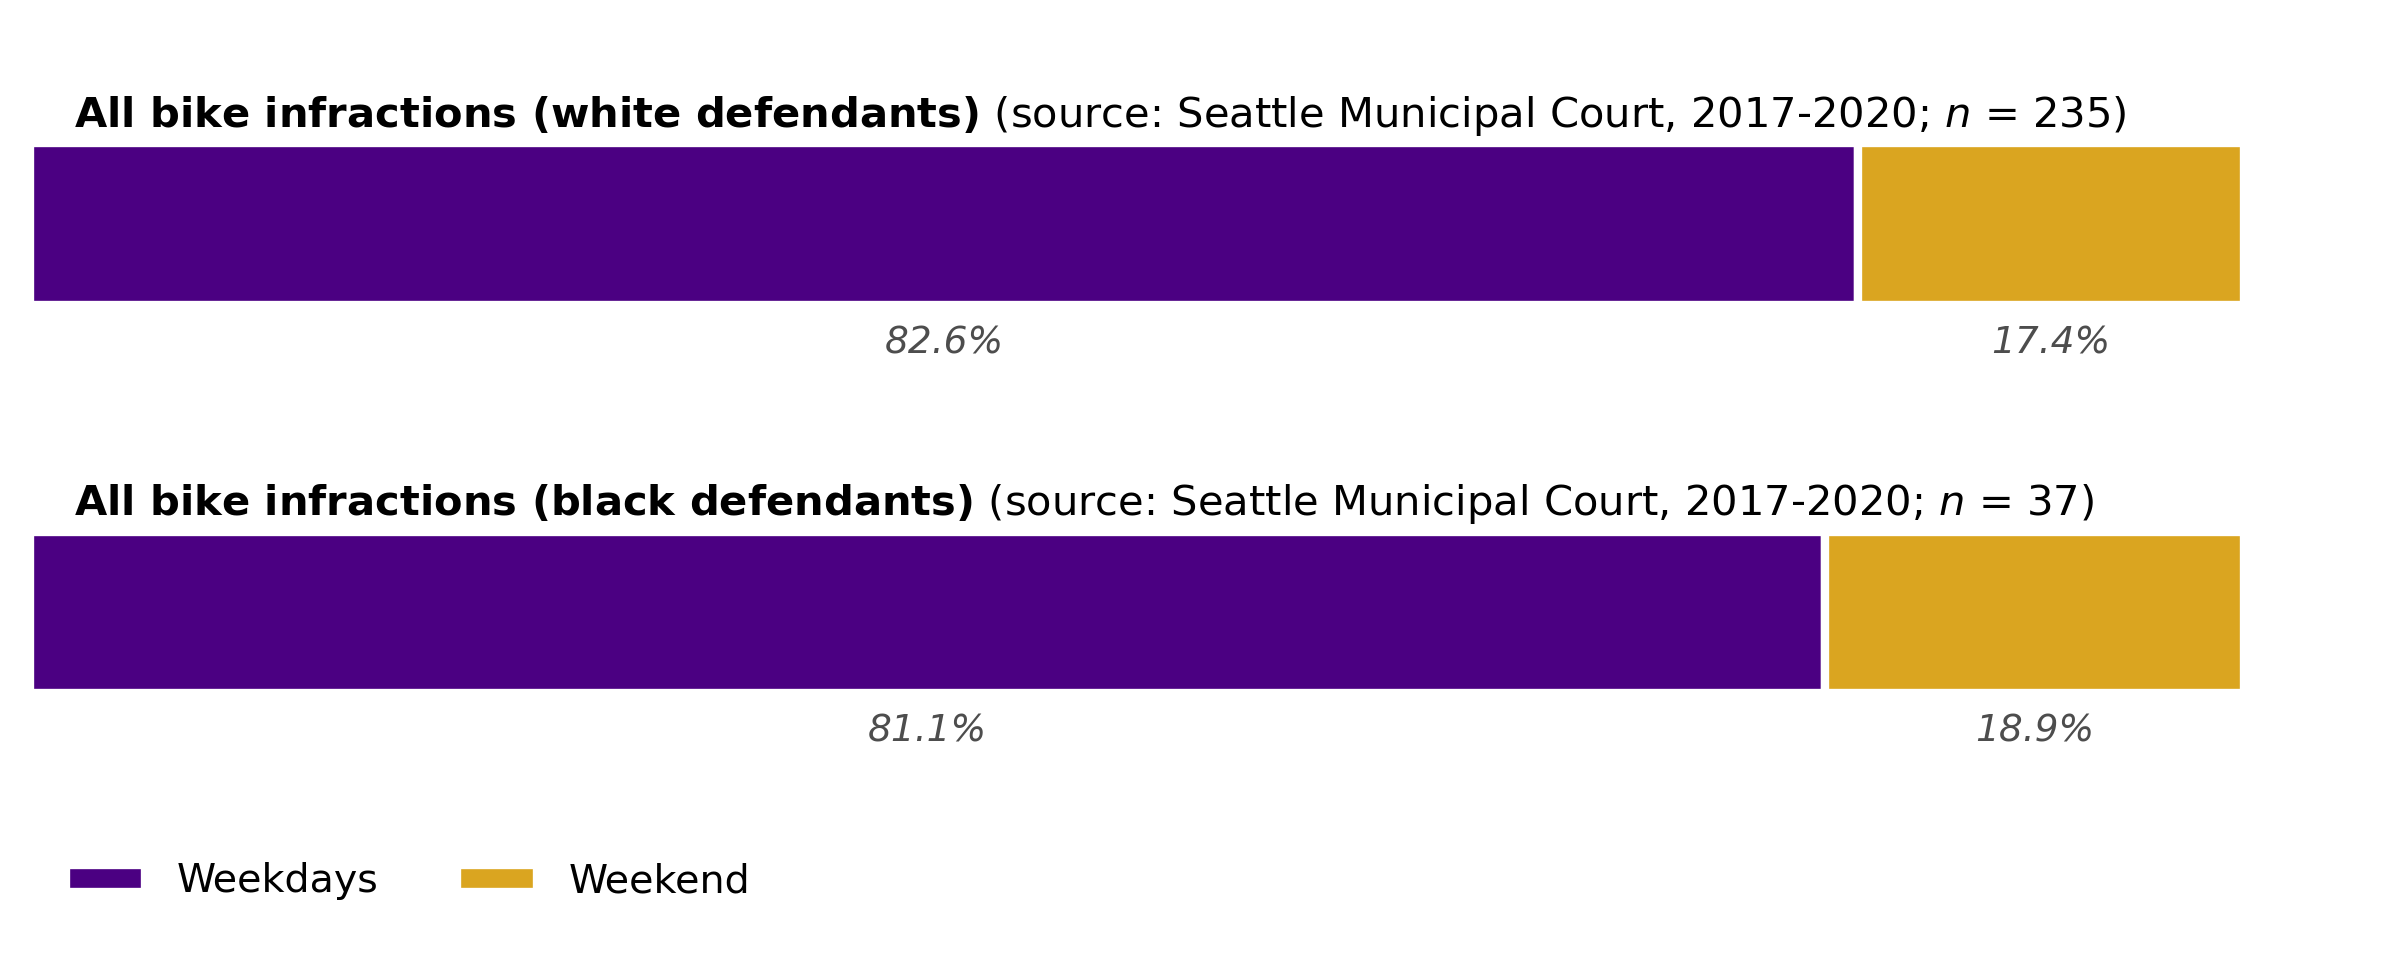

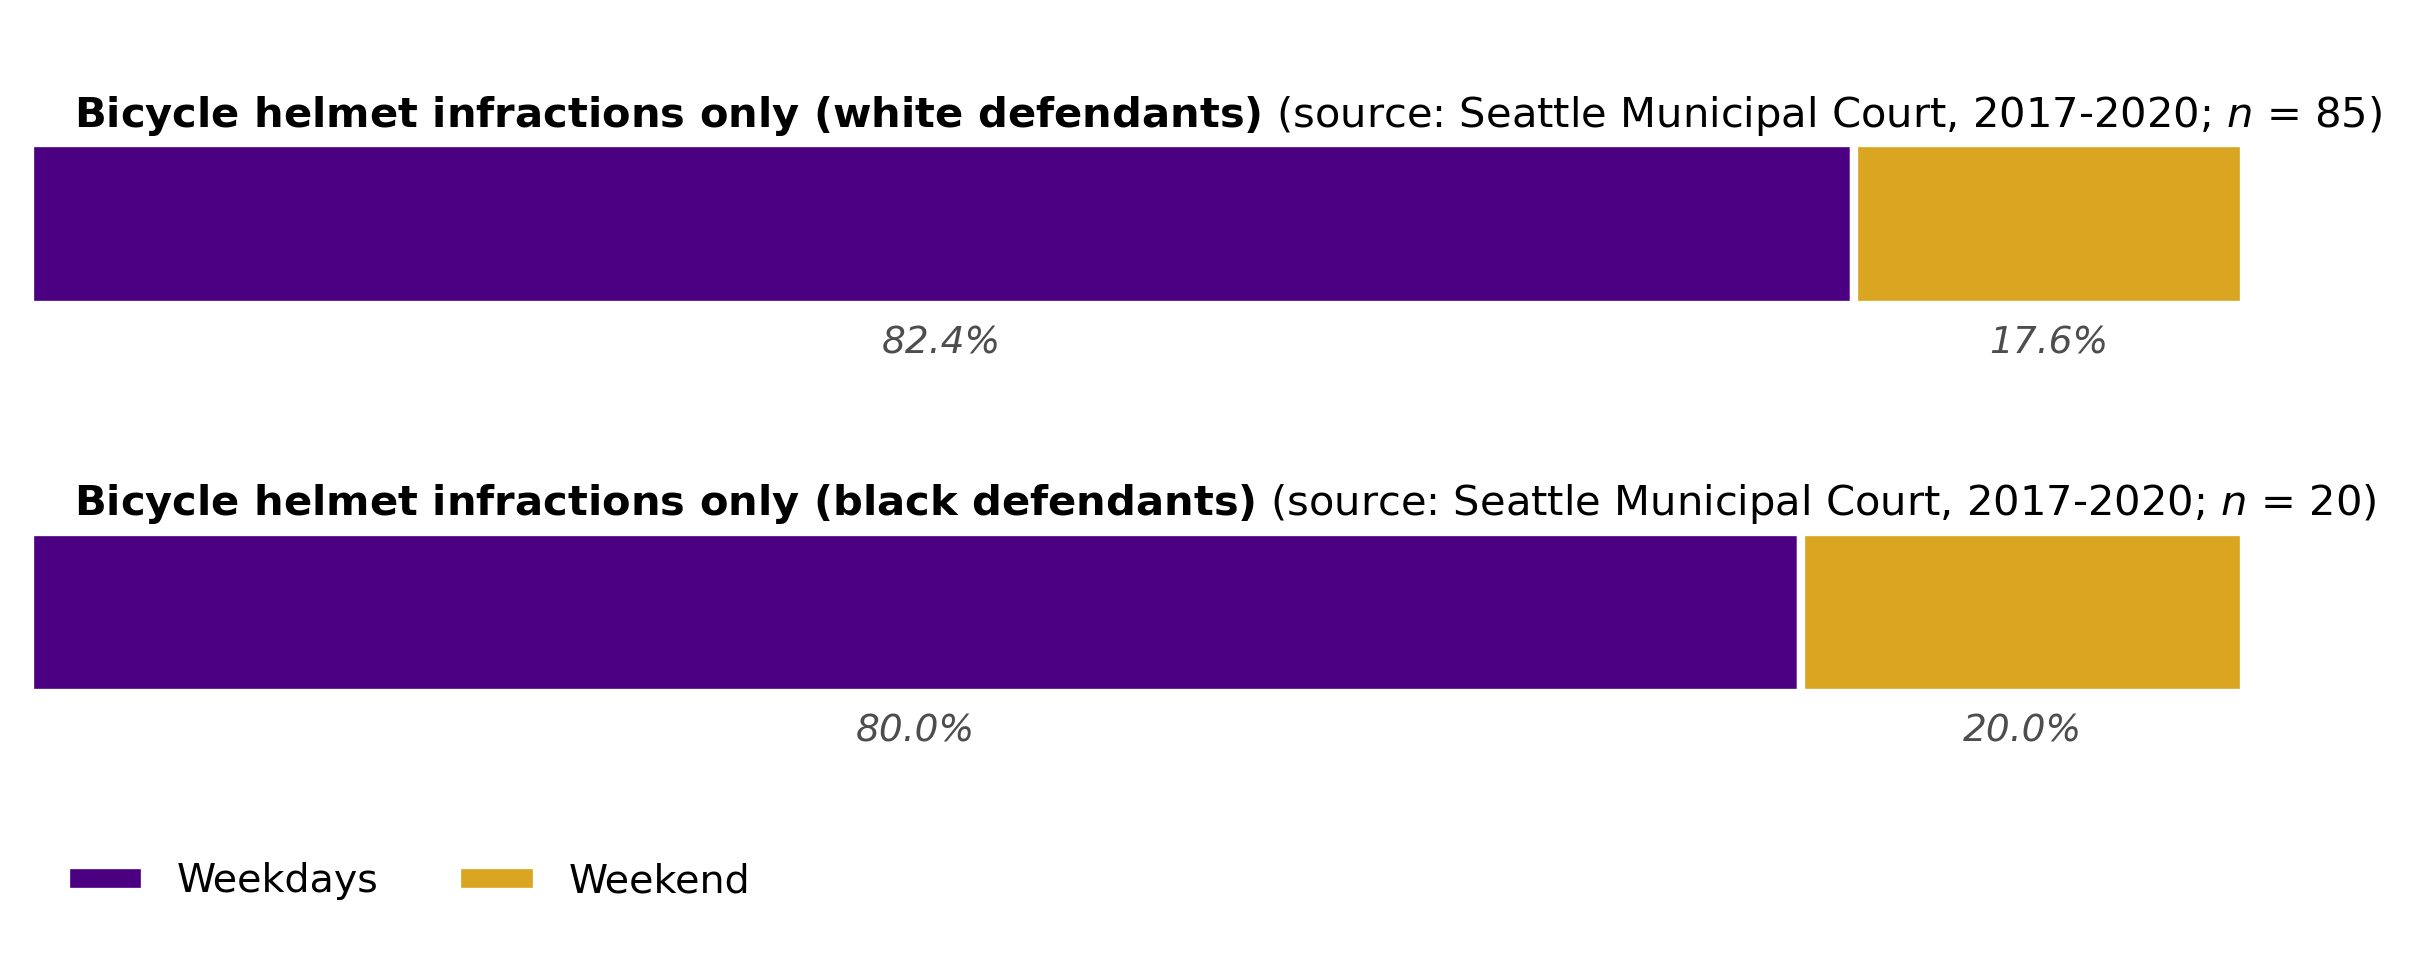

In [215]:
# analysis of weekdays in which infractions were written

dows_all_white = histogram([dt.dayofweek for dt in seattle_mc_new['Violation Date'][seattle_mc_new['Defendant Race'] == 'W']],
                           bins=arange(0,8))
dows_all_black = histogram([dt.dayofweek for dt in seattle_mc_new['Violation Date'][seattle_mc_new['Defendant Race'] == 'B']],
                           bins=arange(0,8))
dows_helmet_white = histogram([dt.dayofweek for dt in seattle_mc_new_helmet['Violation Date'][seattle_mc_new_helmet['Defendant Race'] == 'W']],
                           bins=arange(0,8))
dows_helmet_black = histogram([dt.dayofweek for dt in seattle_mc_new_helmet['Violation Date'][seattle_mc_new_helmet['Defendant Race'] == 'B']],
                           bins=arange(0,8))

which_infractions = [r'$\bf{All~bike~infractions~',r'$\bf{Bicycle~helmet~infractions~only~']
for r_idx, dows in enumerate([[dows_all_white,dows_all_black],[dows_helmet_white,dows_helmet_black]]):
    plt.figure(figsize=(10,4),facecolor='w')

    labels = ['Weekdays','Weekend']
    colors = ['indigo','goldenrod']
    bump_label = [0,0]
    label_star = [0,0]
    y_baseline = 2.2
    widths = array([100*sum(dows[0][0][0:5])/sum(dows[0][0]),100*sum(dows[0][0][5:7])/sum(dows[0][0])])
    h1 = plt.barh(y_baseline,widths,height=0.5,left=array([0,*cumsum(widths)[:-1]]),color=colors,edgecolor='w',linewidth=2.0)
    for w_idx, w in enumerate(widths):
        plt.text(array([0,*cumsum(widths)[:-1]])[w_idx] + w/2 + bump_label[w_idx], y_baseline-0.4,'{0:.1f}%{1}'.format(w,'*'*label_star[w_idx]),
                 horizontalalignment='center',fontstyle='italic',color='0.3',fontsize=9)
    plt.text(2,y_baseline+0.3,which_infractions[r_idx] + r'(white~defendants)}$ (source: Seattle Municipal Court, 2017-2020; ' \
                              + '$n$ = {0})'.format(sum(dows[0][0])))

    bump_label = [0,0]
    label_star = [0,0]
    y_baseline = 1.0
    widths = array([100*sum(dows[1][0][0:5])/sum(dows[1][0]),100*sum(dows[1][0][5:7])/sum(dows[1][0])])
    h2 = plt.barh(y_baseline,widths,height=0.5,left=array([0,*cumsum(widths)[:-1]]),color=colors,edgecolor='w',linewidth=2.0)
    for w_idx, w in enumerate(widths):
        plt.text(array([0,*cumsum(widths)[:-1]])[w_idx] + w/2 + bump_label[w_idx], y_baseline-0.4,'{0:.1f}%{1}'.format(w,'*'*label_star[w_idx]),
                 horizontalalignment='center',fontstyle='italic',color='0.3',fontsize=9)
    plt.text(2,y_baseline+0.3,which_infractions[r_idx] + r'(black~defendants)}$ (source: Seattle Municipal Court, 2017-2020; ' \
                              + '$n$ = {0})'.format(sum(dows[1][0])))

    plt.ylim([0,2.8])

    plt.legend(h2,labels,ncol=5,frameon=False,loc='lower left',prop={'size':9.5});
    plt.xticks([]); plt.yticks([])
    plt.gca().spines['top'].set_visible(False); plt.gca().spines['bottom'].set_visible(False); plt.gca().spines['left'].set_visible(False); plt.gca().spines['right'].set_visible(False)


# Plot Seattle court data availability and categories

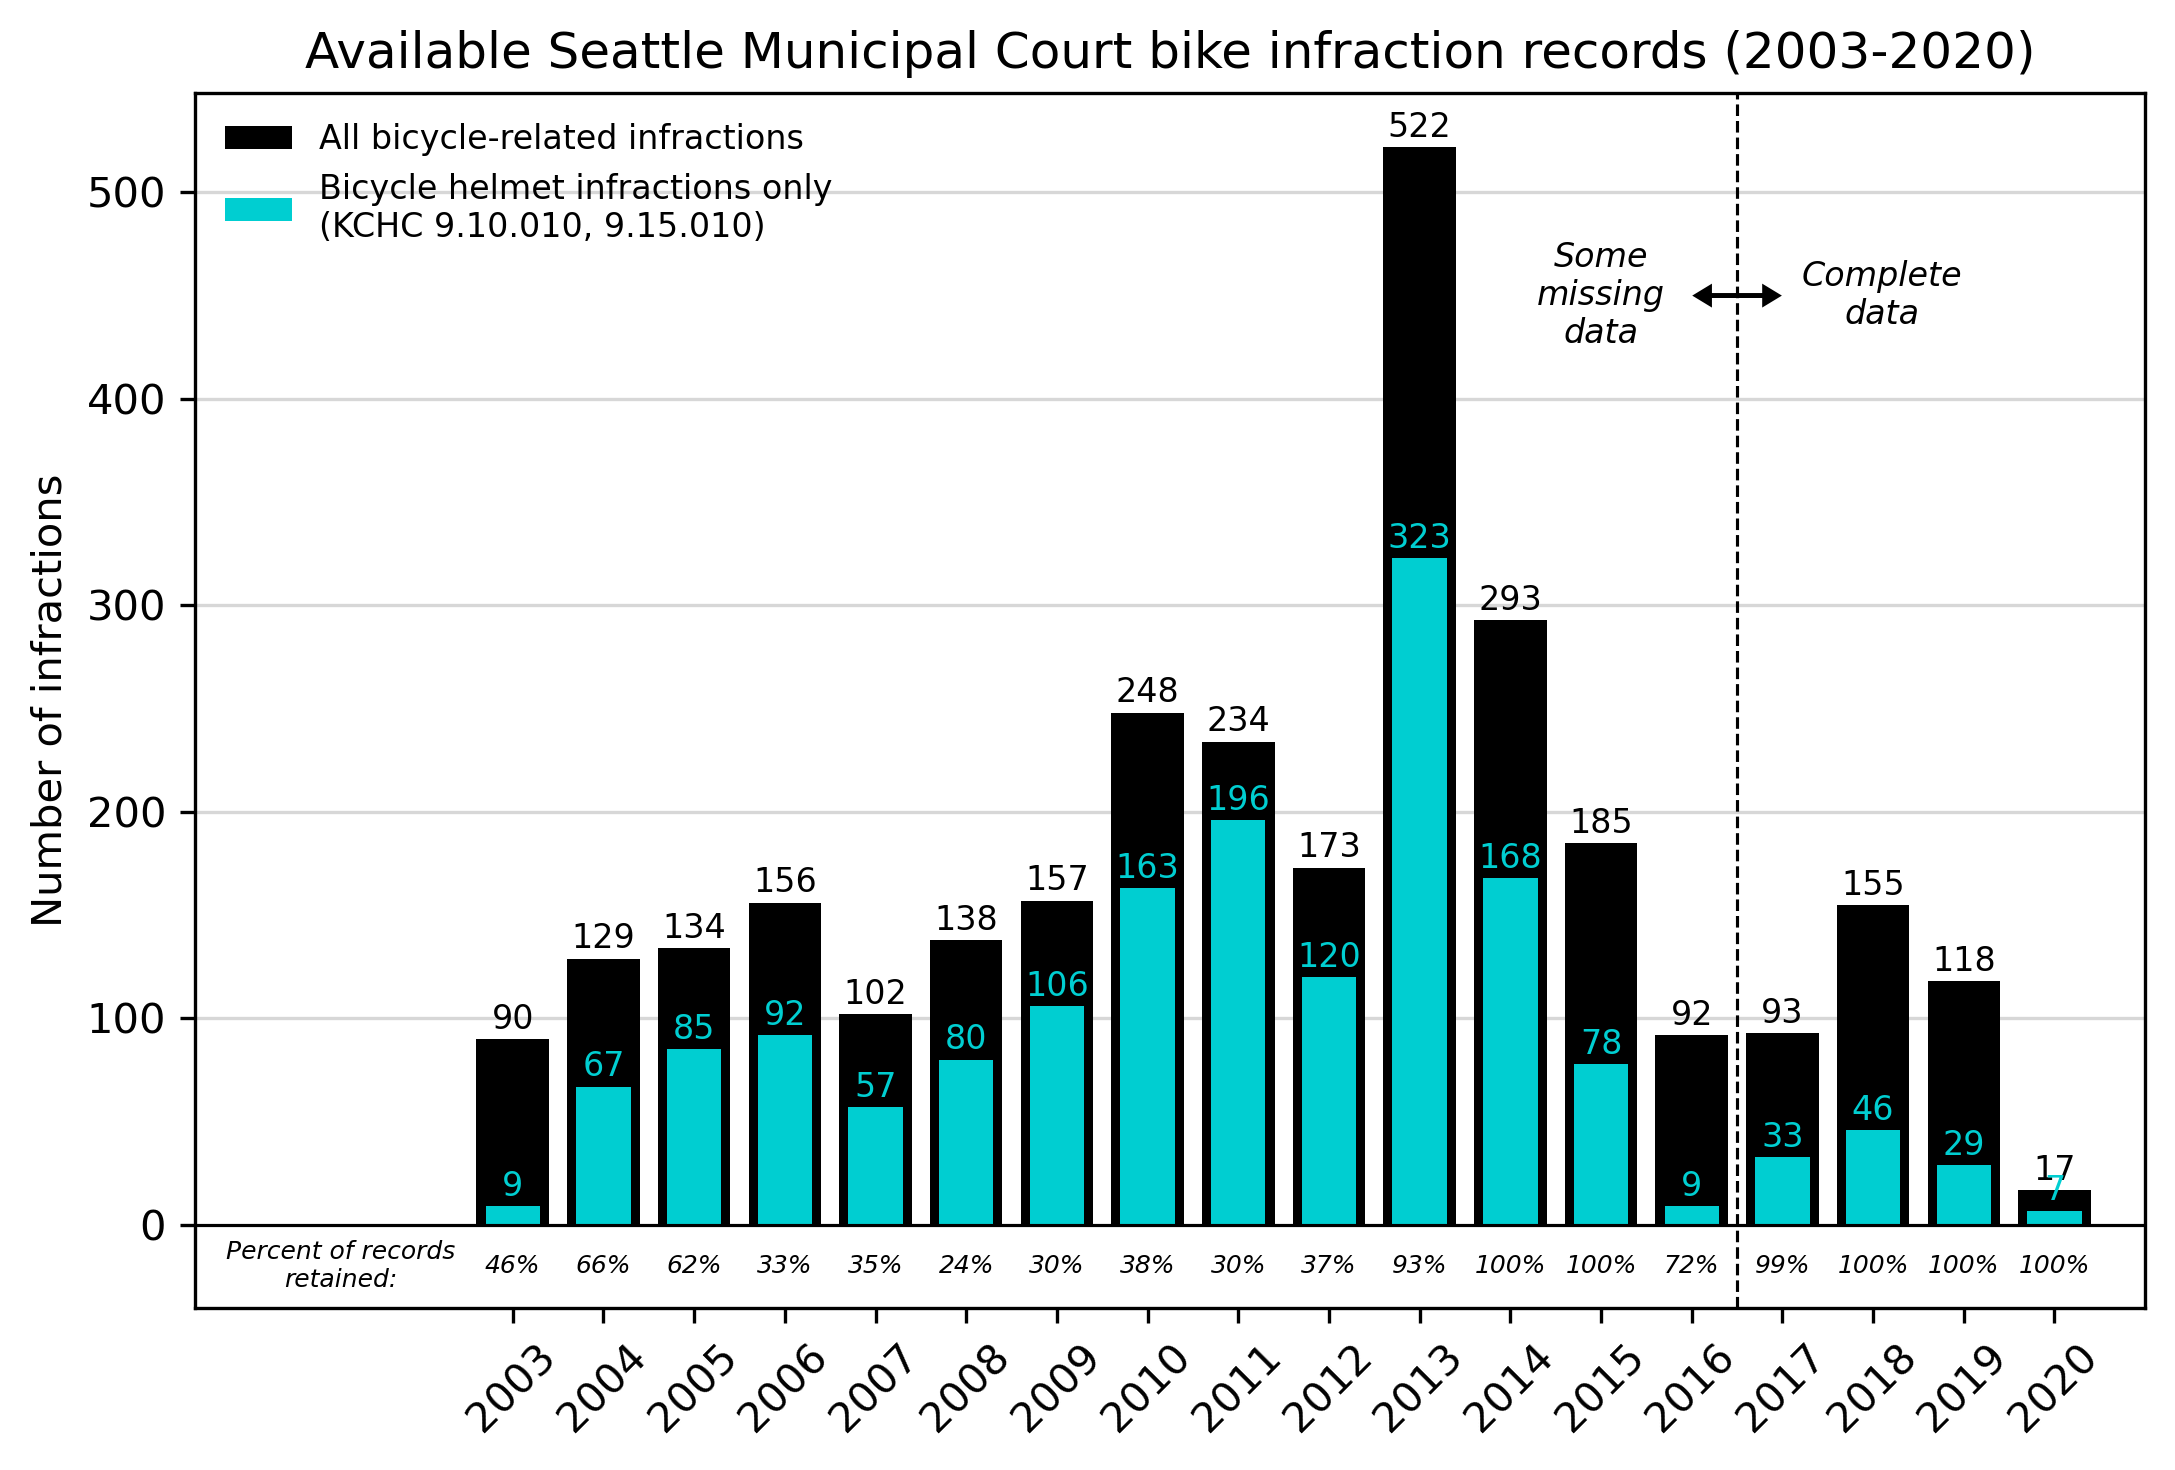

In [218]:
# plot time distribution of older (2003-2016), incomplete Seattle bike infraction records

plt.figure(figsize=(14,5),facecolor='w')
plt.subplot(1,2,1)

old_years_hist = histogram(seattle_mc_old['Violation Date'].dt.year,bins=arange(2003,2018))
x = old_years_hist[1][:-1]
y = old_years_hist[0]
plt.grid(axis='y',alpha=0.5,zorder=1)
plt.bar(x,y,color='k',zorder=2,label='All bicycle-related infractions')
for i, y_val in enumerate(y): plt.text(x[i],y_val+5,str(y_val),c='k',
                                       fontweight='regular',fontsize=8,horizontalalignment='center')
    
new_years_hist = histogram(seattle_mc_new['Violation Date'].dt.year,bins=arange(2017,2022))
x = new_years_hist[1][:-1]
y = new_years_hist[0]
plt.grid(axis='y',zorder=1)
plt.bar(x,y,color='k',zorder=2)
for i, y_val in enumerate(y): plt.text(x[i],y_val+5,str(y_val),c='k',
                                       fontweight='regular',fontsize=8,horizontalalignment='center')

old_years_helmet_hist = histogram(seattle_mc_old_helmet['Violation Date'].dt.year,bins=arange(2003,2018))
x = old_years_helmet_hist[1][:-1]
y = old_years_helmet_hist[0]
plt.bar(x,y,color='darkturquoise',zorder=3,width=0.6,label='Bicycle helmet infractions only\n(KCHC 9.10.010, 9.15.010)')
for i, y_val in enumerate(y): plt.text(x[i],y_val+5,str(y_val),c='darkturquoise',
                                       fontweight='regular',fontsize=8,horizontalalignment='center')
    
new_years_helmet_hist = histogram(seattle_mc_new_helmet['Violation Date'].dt.year,bins=arange(2017,2022))
x = new_years_helmet_hist[1][:-1]
y = new_years_helmet_hist[0]
plt.bar(x,y,color='darkturquoise',zorder=3,width=0.6)
for i, y_val in enumerate(y): plt.text(x[i],y_val+5,str(y_val),c='darkturquoise',
                                       fontweight='regular',fontsize=8,horizontalalignment='center')  
    
old_ylims = plt.ylim()
plt.plot([2016.5,2016.5],[-40,old_ylims[1]],c='k',ls='--',lw=0.75)
plt.arrow(2016.5,450,0.3,0,shape='full',head_length=0.15,head_width=8,color='k')
plt.arrow(2016.5,450,-0.3,0,shape='full',head_length=0.15,head_width=8,color='k')
plt.text(2018.1,450,'Complete\ndata',horizontalalignment='center',verticalalignment='center',style='italic',size=8)
plt.text(2015.0,450,'Some\nmissing\ndata',horizontalalignment='center',verticalalignment='center',style='italic',size=8)

plt.plot([1999.5,2021],[0,0],c='k',lw=0.75,zorder=4)
plt.ylim([-40,old_ylims[1]])
plt.xlim([1999.5,2021])

for year in arange(2003,2021):
    if year <= 2016:
        avail = old_years_hist[0][where(old_years_hist[1] == year)][0]
    elif year >= 2017:
        avail = new_years_hist[0][where(new_years_hist[1] == year)][0]
    frac_avail = min(100,100*avail/seattle_hist_all.loc[year])
    plt.text(year,-20,'{0:.0f}%'.format(frac_avail),horizontalalignment='center',verticalalignment='center',
             style='italic',size=6,color='k')
plt.text(2001.1,-20,'Percent of records\nretained:',horizontalalignment='center',verticalalignment='center',
         style='italic',color='k',size=6)

plt.grid(zorder=0,axis='y')
plt.legend(frameon=False,fontsize=8)
plt.xticks(arange(2003,2021),rotation=45)
plt.ylabel('Number of infractions')
plt.title('Available Seattle Municipal Court bike infraction records (2003-2020)')
plt.tight_layout()

In [223]:
# clean up bike infraction descriptions from Seattle Municipal Court records

seattle_mc_violation_description_updates = {'BIKE  RIDER RIGHTS/DUTIES VIOLATION':'RIGHTS AND DUTIES OF RIDERS',
                                            'BIKE, RIDE ON ROAD':'BIKE  RIDING ON ROAD RULES VIOL',
                                            'BIKE, R/W XWALK':'BIKE  R/W IN CROSSWALK',
                                            'BIKE, LAMPS/REFLECTORS':'BIKE  NO/IMPROPER LAMPS/REFLECTORS',
                                            'BIKE, PASS, RIGHT':'BIKE  UNSAFE PASS ON RIGHT',
                                            'BIKE, HAND SIGNALS':'BIKE  NO/IMPROPER HAND SIGNALS',
                                            'BIKE, CONTROL':'BIKE  CONTROL  ONE HAND MIN REQ\'D',
                                            'BIKE, YIELD R/W':'BIKE  YIELD R/W ON PUBLIC PATH',
                                            'BIKE, NO BRAKES':'BIKE  NO/IMPROPER BRAKES',
                                            'BIKE, CLINGING TO VEH':'BIKE  CLINGING/ATTACHING TO VEHICLE'}
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for old_value in seattle_mc_violation_description_updates.keys():
        seattle_mc_combined['Violation Description'][seattle_mc_combined['Violation Description'] == old_value] \
            = seattle_mc_violation_description_updates[old_value]
    
# print tabulation of bike infractions
violation_counts = pd.DataFrame(seattle_mc_combined['Violation Description'].value_counts())
violation_counts['Percent of total'] = 100*violation_counts/sum(violation_counts)
display(violation_counts)

,Violation Description,Percent of total
BICYCLE HELMET REQUIRED,1668,54.922621
RIGHTS AND DUTIES OF RIDERS,928,30.556470
BIKE NO/IMPROPER LAMPS/REFLECTORS,213,7.013500
BIKE R/W IN CROSSWALK,69,2.271979
BIKE RIDING ON ROAD RULES VIOL,58,1.909779
BIKE UNSAFE PASS ON RIGHT,27,0.889035
BIKE YIELD R/W ON PUBLIC PATH,21,0.691472
BIKE NO/IMPROPER HAND SIGNALS,20,0.658545
BIKE NO/IMPROPER BRAKES,12,0.395127
BIKE CONTROL ONE HAND MIN REQ'D,8,0.263418


# Demographic analysis of February 2018 SDOT/EMC Bike Share Pilot Evaluation Report Survey

* For survey variables key, see file '18-6702 - Syntax.sps'
* For published analysis of survey, see Hirsch et al. (2019): https://www.frontiersin.org/articles/10.3389/fbuil.2019.00017/full
* For EMC graphics summarizing survey responses, see: https://www.seattle.gov/Documents/Departments/SDOT/BikeProgram/APPENDIXC-EMCreport.pdf

In [24]:
# load and parse EMC survey data
emc_survey_raw = pd.read_spss(data_dir + '2020-08-24 - SDOT:EMC 2018 Bike Share Pilot Evaluation Report Survey/18-6702 - Final Weighted Data.sav')
emc_survey = pd.DataFrame({'Race/ethnicity':emc_survey_raw['qx2'],'Biking frequency':emc_survey_raw['Q18'],
                           'Zip code':emc_survey_raw['Q2_1'],'Year born':emc_survey_raw['Q3_1'],
                           'Gender':emc_survey_raw['Q4']})

# merge 'Something else' and 'Prefer not to respond' race/ethnicity categories
emc_survey['Race/ethnicity'] = emc_survey['Race/ethnicity'].cat.rename_categories({'Something else':'Something else/prefer not to respond'})
emc_survey['Race/ethnicity'][emc_survey['Race/ethnicity'] == 'Prefer not to respond'] = 'Something else/prefer not to respond'
emc_survey['Race/ethnicity'] = emc_survey['Race/ethnicity'].cat.remove_categories('Prefer not to respond')

# summary stats
emc_survey_demo_counts = emc_survey['Race/ethnicity'].value_counts()
emc_survey_freq_counts = emc_survey['Biking frequency'].value_counts()
print('2018 SDOT/EMC survey respondent demographics:')
display(emc_survey_demo_counts)
print('NOTE: no responses from Native American/Alaskan Native people\n')
print('2018 SDOT/EMC survey respondent cycling frequency counts:')
display(emc_survey_freq_counts)
print('\nTotal number of responses: ',len(emc_survey))

2018 SDOT/EMC survey respondent demographics:


White or Caucasian                      383
Asian/Pacific Islander                   94
African-American/Black                   47
Hispanic or Latino                       42
Something else/prefer not to respond     35
Name: Race/ethnicity, dtype: int64

NOTE: no responses from Native American/Alaskan Native people

2018 SDOT/EMC survey respondent cycling frequency counts:


I have not biked in the last six months    295
3 to 10 times                              120
1 to 2 times                                75
More than 20 times                          58
11 to 20 times                              53
Name: Biking frequency, dtype: int64


Total number of responses:  601


In [25]:
# load census data for Seattle only
seattle_census = load_census('Seattle',1).loc[2018]
print('2018 US Census Bureau ACS demographics for Seattle:')
display(seattle_census)
assert(seattle_census['Asian_PacIs'] + seattle_census['Black'] + seattle_census['NativeAm_AlaskanNat'] 
       + seattle_census['Other'] + seattle_census['White_HispLat'] + seattle_census['White_Non_HispLat'] == 100.0)

# race/ethnicity weighting (to make EMC survey data representative of Seattle as a whole)
emc_survey_demo_weights = 100 * emc_survey_demo_counts.copy() / sum(emc_survey_demo_counts)
emc_survey_demo_weights['White or Caucasian'] = seattle_census['White_Non_HispLat'] / emc_survey_demo_weights['White or Caucasian']
emc_survey_demo_weights['Asian/Pacific Islander'] = seattle_census['Asian_PacIs'] / emc_survey_demo_weights['Asian/Pacific Islander']
emc_survey_demo_weights['African-American/Black'] = seattle_census['Black'] / emc_survey_demo_weights['African-American/Black']
emc_survey_demo_weights['Hispanic or Latino'] = seattle_census['White_HispLat'] / emc_survey_demo_weights['Hispanic or Latino']
emc_survey_demo_weights['Something else/prefer not to respond'] = seattle_census['Other'] / emc_survey_demo_weights['Something else/prefer not to respond']
print('\nDemographic weights for EMC survey:')
display(emc_survey_demo_weights)

# cycling frequency weighting (to weight EMC survey respondents by how frequently they bike)
# NOTE: this doesn't account for any variations in miles ridden per day
# NOTE: respondents who bike more than 20 times in 6 months fall approximately into the following categories from the
#       2013 SDOT phone survey: respondents who ride:
#           - 'A few times a month' (17%) — which we'll approximate as 4 times a month
#           - 'A few times a week' (11%) — which we'll approximate as 4.33 * 2 = 9 times a month
#           - 'Ride daily' (8%) – which we'll approximate as 4.33 * 5 = 22 times a month
#       ... and we'll use this weighting for EMC survey respondents who reported riding 'More than 20 times' in 6 months
emc_survey_freq_weights = emc_survey_freq_counts.copy()
emc_survey_freq_weights['I have not biked in the last six months'] = 0.0
emc_survey_freq_weights['1 to 2 times'] = mean(arange(1,2+1))
emc_survey_freq_weights['3 to 10 times'] = mean(arange(3,10+1))
emc_survey_freq_weights['11 to 20 times'] = mean(arange(11,20+1))
emc_survey_freq_weights['More than 20 times'] = 6 * (17*4 + 11*9 + 8*22) / (17+11+8)
print('\nCycling frequency weights for EMC survey:')
display(emc_survey_freq_weights)

# assign weights (race/ethnicity and cycling frequency) to respondents who reported cycling in last 6 months
emc_survey_cyclists_only = emc_survey[emc_survey['Biking frequency'] != 'I have not biked in the last six months'].copy()
emc_survey_cyclists_only['Race/ethnicity weight'] = zeros(len(emc_survey_cyclists_only))
emc_survey_cyclists_only['Cycling frequency weight'] = zeros(len(emc_survey_cyclists_only))
for c_idx in emc_survey_cyclists_only.index:
    emc_survey_cyclists_only.loc[c_idx,'Race/ethnicity weight'] \
        = emc_survey_demo_weights[emc_survey_cyclists_only.loc[c_idx,'Race/ethnicity']]
    emc_survey_cyclists_only.loc[c_idx,'Cycling frequency weight'] \
        = emc_survey_freq_weights[emc_survey_cyclists_only.loc[c_idx,'Biking frequency']]

2018 US Census Bureau ACS demographics for Seattle:


Total_population       744949.0
Asian_PacIs                19.3
Black                       8.0
NativeAm_AlaskanNat         1.3
White                      66.9
Other                       4.5
White_HispLat               7.3
White_Non_HispLat          59.6
Name: 2018, dtype: object


Demographic weights for EMC survey:


White or Caucasian                      0.935238
Asian/Pacific Islander                  1.233968
African-American/Black                  1.022979
Hispanic or Latino                      1.044595
Something else/prefer not to respond    0.772714
Name: Race/ethnicity, dtype: float64


Cycling frequency weights for EMC survey:


I have not biked in the last six months     0.000000
3 to 10 times                               6.500000
1 to 2 times                                1.500000
More than 20 times                         57.166667
11 to 20 times                             15.500000
Name: Biking frequency, dtype: float64

In [26]:
# multiply weights to estimate demographics of Seattle cyclists, accounting for individual cycling frequency
emc_survey_cyclists_only['Final weight'] \
    = emc_survey_cyclists_only['Race/ethnicity weight'] * emc_survey_cyclists_only['Cycling frequency weight']

emc_survey_demo_weighted_sums = emc_survey_cyclists_only.groupby(by='Race/ethnicity').sum()['Race/ethnicity weight']
emc_survey_cyclist_demos_without_freq = 100 * emc_survey_demo_weighted_sums / sum(emc_survey_demo_weighted_sums)
print('Seattle cyclist demographics (NON-frequency-weighted) inferred from EMC survey:')
display(emc_survey_cyclist_demos_without_freq)

emc_survey_fully_weighted_sums = emc_survey_cyclists_only.groupby(by='Race/ethnicity').sum()['Final weight']
emc_survey_cyclist_demos = 100 * emc_survey_fully_weighted_sums / sum(emc_survey_fully_weighted_sums)
print('\nSeattle cyclist demographics (frequency-weighted) inferred from EMC survey:')
display(emc_survey_cyclist_demos)

Seattle cyclist demographics (NON-frequency-weighted) inferred from EMC survey:


Race/ethnicity
African-American/Black                  11.132131
Asian/Pacific Islander                  17.497264
Hispanic or Latino                       9.300570
Something else/prefer not to respond     2.548101
White or Caucasian                      59.521934
Name: Race/ethnicity weight, dtype: float64


Seattle cyclist demographics (frequency-weighted) inferred from EMC survey:


Race/ethnicity
African-American/Black                   9.316732
Asian/Pacific Islander                  18.224617
Hispanic or Latino                       5.798934
Something else/prefer not to respond     0.697290
White or Caucasian                      65.962428
Name: Final weight, dtype: float64

# Demographic analysis of November 2019 SDOT/PRR New Mobility Survey

* For survey variables key, see spreadsheet tab 'Codebook - variable values' in main spreadsheet
* For PRR report and graphics summarizing survey responses, see: https://www.seattle.gov/Documents/Departments/SDOT/BikeProgram/AppendixB_NewMobilitySurvey.pdf

In [27]:
# load PRR survey data
prr_survey_raw = pd.read_spss(data_dir + '2020-08-25 - SDOT:PRR New Mobility Survey/New Mobility - final dataset 020520.sav')

In [28]:
# parse PRR survey data
prr_survey = pd.DataFrame({'Seattle resident':prr_survey_raw['Q48'],
                           'Survey segment':prr_survey_raw['Segment_Re'],
                           'Used personal bike in past 12 months':prr_survey_raw['Q11_15'],
                           'Used bike share in past 12 months':prr_survey_raw['Q16_4'],
                           'Ethnicity: Hispanic':prr_survey_raw['Q6'],
                           'Race: NativeAm_AlaskanNat':prr_survey_raw['Q7_1'],
                           'Race: Asian':prr_survey_raw['Q7_2'],
                           'Race: Black':prr_survey_raw['Q7_3'],
                           'Race: PacIs':prr_survey_raw['Q7_4'],
                           'Race: White':prr_survey_raw['Q7_5'],
                           'Race: Other':prr_survey_raw['Q7_6'],
                           'Gender':prr_survey_raw['Q112'],
                           'Household income':prr_survey_raw['Q118'],
                           'Bike share frequency in past 12 months':prr_survey_raw['A4_Q19']})

# even if multiple races selected, assign according to the following heuristic:
for r_idx in prr_survey.index:
    prr_survey.loc[r_idx,'Race/ethnicity'] = NaN
    if prr_survey.loc[r_idx,'Race: Black'] == 'Black or African American':
        prr_survey.loc[r_idx,'Race/ethnicity'] = 'African-American/Black'
    elif prr_survey.loc[r_idx,'Ethnicity: Hispanic'] == 'Yes':
        prr_survey.loc[r_idx,'Race/ethnicity'] = 'Hispanic or Latino'
    elif prr_survey.loc[r_idx,'Race: Asian'] == 'Asian or Asian American' \
      or prr_survey.loc[r_idx,'Race: PacIs'] == 'Native Hawaiian or Pacific Islander':
        prr_survey.loc[r_idx,'Race/ethnicity'] = 'Asian/Pacific Islander'
    elif prr_survey.loc[r_idx,'Race: NativeAm_AlaskanNat'] == 'American Indian or Alaska Native':
        prr_survey.loc[r_idx,'Race/ethnicity'] = 'Native American/Alaska Native'
    elif prr_survey.loc[r_idx,'Race: White'] == 'White':
        prr_survey.loc[r_idx,'Race/ethnicity'] = 'White or Caucasian'
    else:
        prr_survey.loc[r_idx,'Race/ethnicity'] = 'Something else/prefer not to respond'

# consider respondent a cyclist if they used a personal bike/e-bike or bike share within the past 12 months
for r_idx in prr_survey.index:
    prr_survey.loc[r_idx,'Cyclist'] = NaN
    if prr_survey.loc[r_idx,'Used personal bike in past 12 months'] == 'Bike or e-bike you or someone you know owns' \
    or prr_survey.loc[r_idx,'Used bike share in past 12 months'] == 'Bike share (Lime, Jump, etc.)':
        prr_survey.loc[r_idx,'Cyclist'] = 'Yes'
    elif prr_survey.loc[r_idx,'Used personal bike in past 12 months'] == 0 \
     and prr_survey.loc[r_idx,'Used bike share in past 12 months'] == 0:
        prr_survey.loc[r_idx,'Cyclist'] = 'No'
        
# select Seattle residents only
prr_survey_seattle_only = prr_survey[prr_survey['Seattle resident'] == 'Yes'].copy()

# summary stats
prr_survey_demo_counts = prr_survey_seattle_only['Race/ethnicity'].value_counts()
prr_survey_bike_counts = prr_survey_seattle_only['Cyclist'].value_counts()
print('2019 SDOT/PRR survey respondent demographics (Seattle residents only):')
display(prr_survey_demo_counts)
print('\n2019 SDOT/PRR survey respondent cyclist statistics (Seattle residents only):')
display(prr_survey_bike_counts)
print('\nTotal number of responses (Seattle residents only): ',len(prr_survey_seattle_only))

2019 SDOT/PRR survey respondent demographics (Seattle residents only):


White or Caucasian                      1698
Asian/Pacific Islander                   295
Something else/prefer not to respond     288
Hispanic or Latino                       131
African-American/Black                    80
Native American/Alaska Native             22
Name: Race/ethnicity, dtype: int64


2019 SDOT/PRR survey respondent cyclist statistics (Seattle residents only):


No     1201
Yes    1127
Name: Cyclist, dtype: int64


Total number of responses (Seattle residents only):  2514


In [29]:
# load census data for Seattle only
seattle_census = load_census('Seattle',1).loc[2018]
print('2018 US Census Bureau ACS demographics for Seattle (used 2018 because 2019 not available):')
display(seattle_census)
assert(seattle_census['Asian_PacIs'] + seattle_census['Black'] + seattle_census['NativeAm_AlaskanNat'] 
       + seattle_census['Other'] + seattle_census['White_HispLat'] + seattle_census['White_Non_HispLat'] == 100.0)

# race/ethnicity weighting (to make PRR survey data representative of Seattle as a whole)
prr_survey_demo_weights = 100 * prr_survey_demo_counts.copy() / sum(prr_survey_demo_counts)
prr_survey_demo_weights['White or Caucasian'] = seattle_census['White_Non_HispLat'] / prr_survey_demo_weights['White or Caucasian']
prr_survey_demo_weights['Asian/Pacific Islander'] = seattle_census['Asian_PacIs'] / prr_survey_demo_weights['Asian/Pacific Islander']
prr_survey_demo_weights['African-American/Black'] = seattle_census['Black'] / prr_survey_demo_weights['African-American/Black']
prr_survey_demo_weights['Hispanic or Latino'] = seattle_census['White_HispLat'] / prr_survey_demo_weights['Hispanic or Latino']
prr_survey_demo_weights['Native American/Alaska Native'] = seattle_census['NativeAm_AlaskanNat'] / prr_survey_demo_weights['Native American/Alaska Native']
prr_survey_demo_weights['Something else/prefer not to respond'] = seattle_census['Other'] / prr_survey_demo_weights['Something else/prefer not to respond']
print('\nDemographic weights for PRR survey:')
display(prr_survey_demo_weights)

# REVISIT THIS: cycling frequency weighting (to weight PRR survey respondents by how frequently they bike)
# NOTE: this doesn't account for any variations in miles ridden per day
# METHODOLOGY: I'm using the 2018 SDOT/EMC survey data results to estimate weightings by race/ethnicity category
#              for cycling frequency (e.g. based on how over- or under-represented cyclists of a given category
#              are in the EMC data when accounting for cycling frequency vs. when not accounting for cycling frequency)
prr_survey_freq_weights = emc_survey_cyclist_demos / emc_survey_cyclist_demos_without_freq
prr_survey_freq_weights = pd.Series(index=prr_survey_freq_weights.reset_index()['Race/ethnicity'].astype(str),
                                    data=prr_survey_freq_weights.reset_index()[0].values)
prr_survey_freq_weights['Native American/Alaska Native'] = 1.0
print('\nCycling frequency weights for PRR survey (based off results of 2018 SDOT/EMC survey):')
display(prr_survey_freq_weights)

# assign weights (race/ethnicity and cycling frequency) to respondents who reported cycling in last 6 months
prr_survey_cyclists_only = prr_survey_seattle_only[prr_survey_seattle_only['Cyclist'] == 'Yes'].copy()
prr_survey_cyclists_only['Race/ethnicity weight'] = zeros(len(prr_survey_cyclists_only))
prr_survey_cyclists_only['Cycling frequency weight'] = zeros(len(prr_survey_cyclists_only))
for c_idx in prr_survey_cyclists_only.index:
    prr_survey_cyclists_only.loc[c_idx,'Race/ethnicity weight'] \
        = prr_survey_demo_weights[prr_survey_cyclists_only.loc[c_idx,'Race/ethnicity']]
    prr_survey_cyclists_only.loc[c_idx,'Cycling frequency weight'] \
        = prr_survey_freq_weights[prr_survey_cyclists_only.loc[c_idx,'Race/ethnicity']]

2018 US Census Bureau ACS demographics for Seattle (used 2018 because 2019 not available):


Total_population       744949.0
Asian_PacIs                19.3
Black                       8.0
NativeAm_AlaskanNat         1.3
White                      66.9
Other                       4.5
White_HispLat               7.3
White_Non_HispLat          59.6
Name: 2018, dtype: object


Demographic weights for PRR survey:


White or Caucasian                      0.882417
Asian/Pacific Islander                  1.644753
Something else/prefer not to respond    0.392813
Hispanic or Latino                      1.400931
African-American/Black                  2.514000
Native American/Alaska Native           1.485545
Name: Race/ethnicity, dtype: float64


Cycling frequency weights for PRR survey (based off results of 2018 SDOT/EMC survey):


Race/ethnicity
African-American/Black                  0.836923
Asian/Pacific Islander                  1.041570
Hispanic or Latino                      0.623503
Something else/prefer not to respond    0.273651
White or Caucasian                      1.108204
Native American/Alaska Native           1.000000
dtype: float64

In [30]:
# multiply weights to estimate demographics of Seattle cyclists, accounting for individual cycling frequency
prr_survey_cyclists_only['Final weight'] \
    = prr_survey_cyclists_only['Race/ethnicity weight'] * prr_survey_cyclists_only['Cycling frequency weight']

prr_survey_demo_weighted_sums = prr_survey_cyclists_only.groupby(by='Race/ethnicity').sum()['Race/ethnicity weight']
prr_survey_cyclist_demos_without_freq = 100 * prr_survey_demo_weighted_sums / sum(prr_survey_demo_weighted_sums)
print('Seattle cyclist demographics (NON-frequency-weighted) inferred from PRR survey:')
display(prr_survey_cyclist_demos_without_freq)

prr_survey_fully_weighted_sums = prr_survey_cyclists_only.groupby(by='Race/ethnicity').sum()['Final weight']
prr_survey_cyclist_demos = 100 * prr_survey_fully_weighted_sums / sum(prr_survey_fully_weighted_sums)
print('\nSeattle cyclist demographics (frequency-weighted using SDOT/EMC results) inferred from PRR survey:')
display(prr_survey_cyclist_demos)

Seattle cyclist demographics (NON-frequency-weighted) inferred from PRR survey:


Race/ethnicity
African-American/Black                   5.677650
Asian/Pacific Islander                  17.235422
Hispanic or Latino                       8.352647
Native American/Alaska Native            0.536796
Something else/prefer not to respond     3.867899
White or Caucasian                      64.329585
Name: Race/ethnicity weight, dtype: float64


Seattle cyclist demographics (frequency-weighted using SDOT/EMC results) inferred from PRR survey:


Race/ethnicity
African-American/Black                   4.714178
Asian/Pacific Islander                  17.809931
Hispanic or Latino                       5.166718
Native American/Alaska Native            0.532551
Something else/prefer not to respond     1.050083
White or Caucasian                      70.726539
Name: Final weight, dtype: float64

# Plot comparison of Seattle bike infraction data, Seattle demographics, and Seattle cyclist demographics

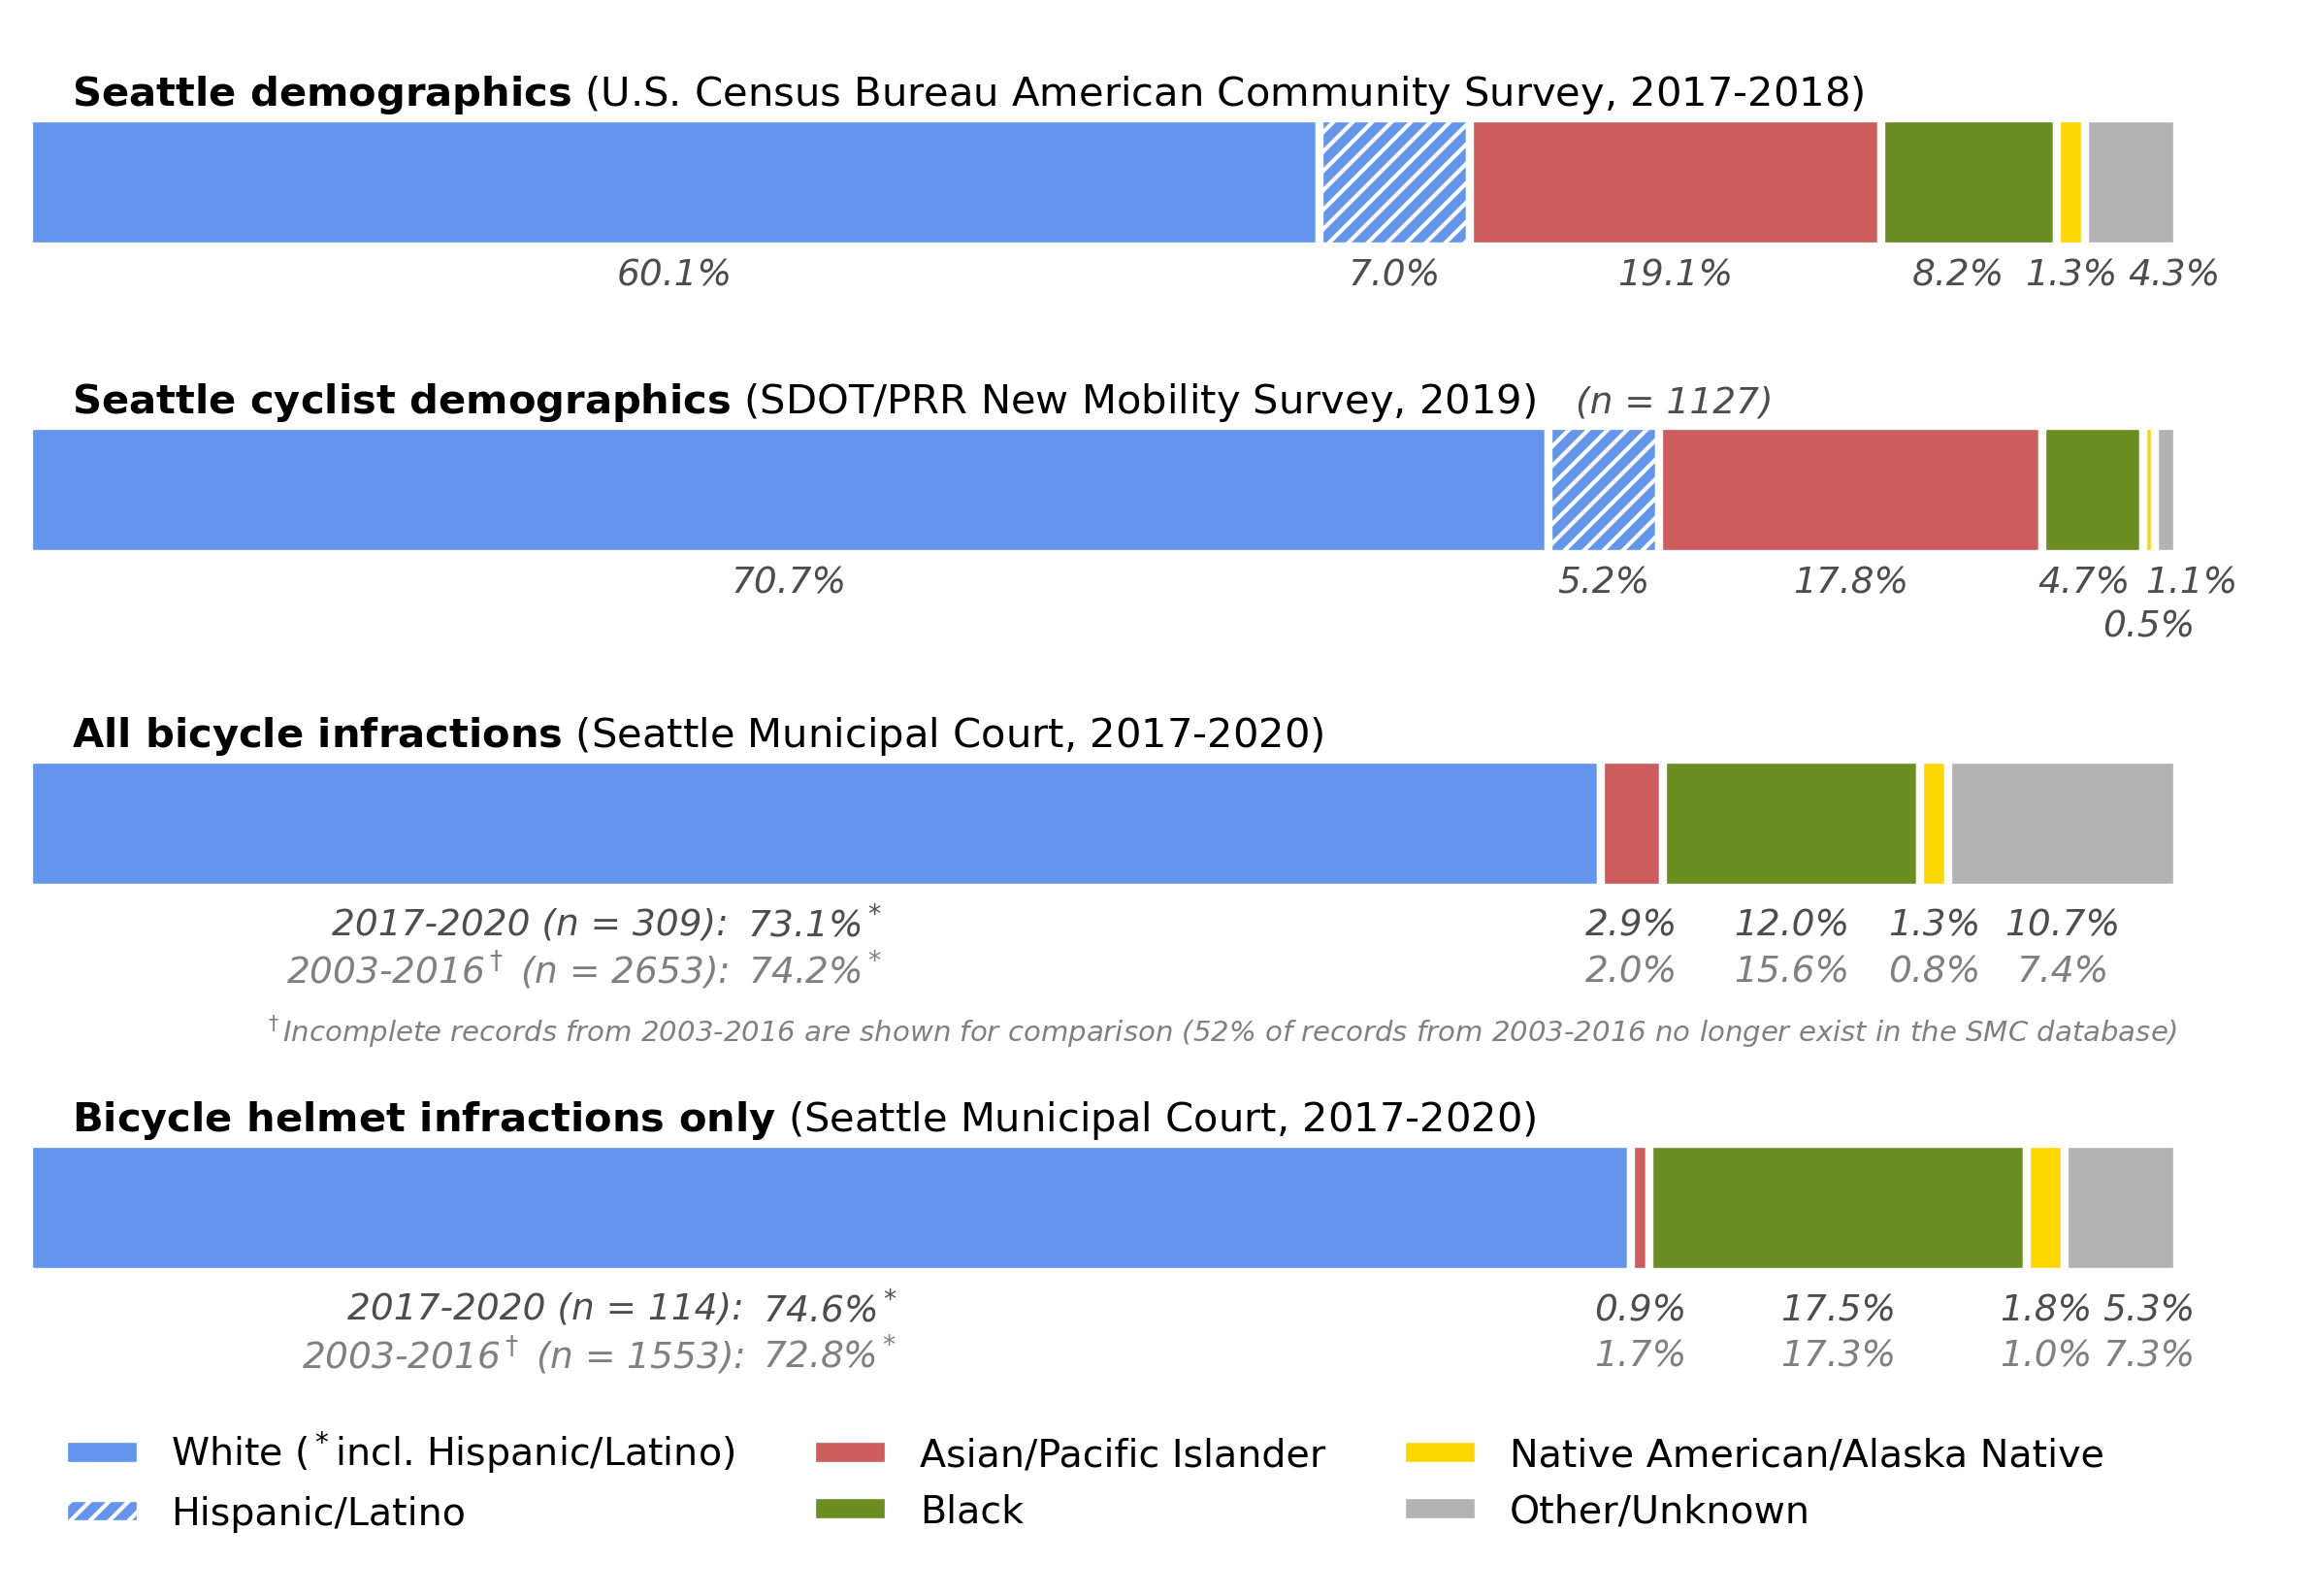

In [226]:
plt.figure(figsize=(10,7),facecolor='w')

seattle_census = load_census('Seattle',1).loc[2017:2018].mean()
labels = ['White ($^*$incl. Hispanic)','Hispanic/Latino','Asian/Pacific Islander','Black',
          'Native American/Alaska Native','Other/Unknown']
colors = ['cornflowerblue','cornflowerblue','indianred','olivedrab','gold','0.7']
bump_label = [0,0,0,-0.5,0,2.0]
label_star = [0,0,0,0,0,0]
y_baseline = 5.4
widths = array([seattle_census['White_Non_HispLat'],
                seattle_census['White_HispLat'],
                seattle_census['Asian_PacIs'],
                seattle_census['Black'],
                seattle_census['NativeAm_AlaskanNat'],
                seattle_census['Other']])
h2 = plt.barh(y_baseline,widths,height=0.5,left=array([0,*cumsum(widths)[:-1]]),color=colors,edgecolor='w',linewidth=2.0)
h2[1].set_hatch('/////')   # for Hispanic/Latino category
for w_idx, w in enumerate(widths):
    plt.text(array([0,*cumsum(widths)[:-1]])[w_idx] + w/2 + bump_label[w_idx], y_baseline-0.4,
             '{0:.1f}%{1}'.format(w,'$^*$'*label_star[w_idx]),
             horizontalalignment='center',fontstyle='italic',color='0.3',fontsize=9)
plt.text(2,y_baseline+0.3,r'$\bf{Seattle~demographics}$ (U.S. Census Bureau American Community Survey, 2017-2018)')

labels = ['White ($^*$incl. Hispanic/Latino)','Hispanic/Latino','Asian/Pacific Islander','Black',
          'Native American/Alaska Native','Other/Unknown']
colors = ['cornflowerblue','cornflowerblue','indianred','olivedrab','gold','0.7']
bump_label = [0,0,0,-0.4,0.0,1.2]
bump_label_v = [0,0,0,0,-0.17,0]
label_star = [0,0,0,0,0,0]
y_baseline = 4.2
widths = array([prr_survey_cyclist_demos['White or Caucasian'],
                prr_survey_cyclist_demos['Hispanic or Latino'],
                prr_survey_cyclist_demos['Asian/Pacific Islander'],
                prr_survey_cyclist_demos['African-American/Black'],
                prr_survey_cyclist_demos['Native American/Alaska Native'],
                prr_survey_cyclist_demos['Something else/prefer not to respond']])
h1 = plt.barh(y_baseline,widths,height=0.5,left=array([0,*cumsum(widths)[:-1]]),color=colors,edgecolor='w',linewidth=2.0)
h1[1].set_hatch('/////')   # for Hispanic/Latino category
for w_idx, w in enumerate(widths):
    plt.text(array([0,*cumsum(widths)[:-1]])[w_idx] + w/2 + bump_label[w_idx], y_baseline - 0.4 + bump_label_v[w_idx],
             '{0:.1f}%{1}'.format(w,'$^*$'*label_star[w_idx]),
             horizontalalignment='center',fontstyle='italic',color='0.3',fontsize=9)
plt.text(2,y_baseline+0.3,r'$\bf{Seattle~cyclist~demographics}$ (SDOT/PRR New Mobility Survey, 2019)')
plt.text(72,y_baseline+0.34,'(n = {0})'.format(prr_survey_bike_counts['Yes']),
         style='italic',color='0.3',verticalalignment='center',fontsize=9)
# plt.text(100,y_baseline-0.6,'$^*$Other/Unknown includes Native American',
#          fontstyle='italic',horizontalalignment='right',color='0.5',fontsize=7)

labels_shorter = ['White (incl. Hispanic/Latino)','Asian/Pacific Islander','Black',
                  'Native American/Alaska Native','Other/Unknown']
colors = ['cornflowerblue','indianred','olivedrab','gold','0.7']
bump_label = [0,0,0,0,0]
label_star = [1,0,0,0,0]
y_baseline = 2.9
widths = array([100 * sum(smc_cleaned_new['Defendant Race'] == 'W') / len(smc_cleaned_new),
                100 * sum(smc_cleaned_new['Defendant Race'] == 'A') / len(smc_cleaned_new),
                100 * sum(smc_cleaned_new['Defendant Race'] == 'B') / len(smc_cleaned_new),
                100 * sum(smc_cleaned_new['Defendant Race'] == 'I') / len(smc_cleaned_new),
                100 * sum(smc_cleaned_new['Defendant Race'] == 'U') / len(smc_cleaned_new)])
widths_old = array([100 * sum(smc_cleaned_old['Defendant Race'] == 'W') / len(smc_cleaned_old),
                    100 * sum(smc_cleaned_old['Defendant Race'] == 'A') / len(smc_cleaned_old),
                    100 * sum(smc_cleaned_old['Defendant Race'] == 'B') / len(smc_cleaned_old),
                    100 * sum(smc_cleaned_old['Defendant Race'] == 'I') / len(smc_cleaned_old),
                    100 * sum(smc_cleaned_old['Defendant Race'] == 'U') / len(smc_cleaned_old)])
h3 = plt.barh(y_baseline,widths,height=0.5,left=array([0,*cumsum(widths)[:-1]]),color=colors,edgecolor='w',linewidth=2.0)
for w_idx, w in enumerate(widths):
    plt.text(array([0,*cumsum(widths)[:-1]])[w_idx] + widths[w_idx]/2 + bump_label[w_idx], y_baseline-0.4,
             '{0:.1f}%{1}'.format(w,'$^*$'*label_star[w_idx]),
             horizontalalignment='center',verticalalignment='center',fontstyle='italic',color='0.3',fontsize=9)
for w_idx, w in enumerate(widths_old):
    plt.text(array([0,*cumsum(widths)[:-1]])[w_idx] + widths[w_idx]/2 + bump_label[w_idx], y_baseline-0.58,
             '{0:.1f}%{1}'.format(w,'$^*$'*label_star[w_idx]),
             horizontalalignment='center',verticalalignment='center',fontstyle='italic',color='0.5',fontsize=9)
plt.text(2,y_baseline+0.3,r'$\bf{All~bicycle~infractions}$ (Seattle Municipal Court, 2017-2020)')
plt.text(widths[0]/2 - 4,y_baseline-0.395,'2017-2020 (n = {0}):'.format(len(smc_cleaned_new)),
         style='italic',horizontalalignment='right',verticalalignment='center',color='0.3',fontsize=9)
plt.text(widths[0]/2 - 4,y_baseline-0.57,'2003-2016$^\dagger$ (n = {0}):'.format(len(smc_cleaned_old)),
         style='italic',horizontalalignment='right',verticalalignment='center',color='0.5',fontsize=9)
percent_missing = 100 * (1 - len(seattle_mc_old)/(sum(seattle_hist_all.loc[2003:2016])))
plt.text(100,y_baseline-0.85,'$^\dagger$Incomplete records from 2003-2016 are shown for comparison ' + \
         '({0:.0f}% of records from 2003-2016 no longer exist in the SMC database)'.format(percent_missing),
         fontstyle='italic',horizontalalignment='right',color='0.5',fontsize=7)

bump_label = [0,0,0,0,1.3]
label_star = [1,0,0,0,0]
y_baseline = 1.4
widths = array([100 * sum(smc_cleaned_new_helmet['Defendant Race'] == 'W') / len(smc_cleaned_new_helmet),
                100 * sum(smc_cleaned_new_helmet['Defendant Race'] == 'A') / len(smc_cleaned_new_helmet),
                100 * sum(smc_cleaned_new_helmet['Defendant Race'] == 'B') / len(smc_cleaned_new_helmet),
                100 * sum(smc_cleaned_new_helmet['Defendant Race'] == 'I') / len(smc_cleaned_new_helmet),
                100 * sum(smc_cleaned_new_helmet['Defendant Race'] == 'U') / len(smc_cleaned_new_helmet)])
widths_old = array([100 * sum(smc_cleaned_old_helmet['Defendant Race'] == 'W') / len(smc_cleaned_old_helmet),
                    100 * sum(smc_cleaned_old_helmet['Defendant Race'] == 'A') / len(smc_cleaned_old_helmet),
                    100 * sum(smc_cleaned_old_helmet['Defendant Race'] == 'B') / len(smc_cleaned_old_helmet),
                    100 * sum(smc_cleaned_old_helmet['Defendant Race'] == 'I') / len(smc_cleaned_old_helmet),
                    100 * sum(smc_cleaned_old_helmet['Defendant Race'] == 'U') / len(smc_cleaned_old_helmet)])
h3 = plt.barh(y_baseline,widths,height=0.5,left=array([0,*cumsum(widths)[:-1]]),color=colors,edgecolor='w',linewidth=2.0)
for w_idx, w in enumerate(widths):
    plt.text(array([0,*cumsum(widths)[:-1]])[w_idx] + widths[w_idx]/2 + bump_label[w_idx], y_baseline-0.4,
             '{0:.1f}%{1}'.format(w,'$^*$'*label_star[w_idx]),
             horizontalalignment='center',verticalalignment='center',fontstyle='italic',color='0.3',fontsize=9)
for w_idx, w in enumerate(widths_old):
    plt.text(array([0,*cumsum(widths)[:-1]])[w_idx] + widths[w_idx]/2 + bump_label[w_idx], y_baseline-0.58,
             '{0:.1f}%{1}'.format(w,'$^*$'*label_star[w_idx]),
             horizontalalignment='center',verticalalignment='center',fontstyle='italic',color='0.5',fontsize=9)
plt.text(2,y_baseline+0.3,r'$\bf{Bicycle~helmet~infractions~only}$ (Seattle Municipal Court, 2017-2020)')
plt.text(widths[0]/2 - 4,y_baseline-0.395,'2017-2020 (n = {0}):'.format(len(smc_cleaned_new_helmet)),
         style='italic',horizontalalignment='right',verticalalignment='center',color='0.3',fontsize=9)
plt.text(widths[0]/2 - 4,y_baseline-0.57,'2003-2016$^\dagger$ (n = {0}):'.format(len(smc_cleaned_old_helmet)),
         style='italic',horizontalalignment='right',verticalalignment='center',color='0.5',fontsize=9)
plt.ylim([0,6.0])

plt.legend(h2,labels,ncol=3,frameon=False,loc='lower left',prop={'size':9.5});
plt.xticks([]); plt.yticks([])
plt.gca().spines['top'].set_visible(False); plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False); plt.gca().spines['right'].set_visible(False)

# plt.savefig('figure.pdf')

# Preliminary analysis of other King County municipalities

In [32]:
# load data from Renton
renton_mc = pd.read_excel(data_dir + '2020-07-22 - Renton Municipal Court helmet infraction data (2007-08-20 to 2020-06-30).xlsx',
                          header=4,index_col=None,parse_dates=[0,5,10])
renton_census = load_census('Renton',1).loc[2010:2018].mean()
print('Renton MC white',100 * sum(renton_mc['Person Race Code'] == 'W') / len(renton_mc))
print('Renton MC Black',100 * sum(renton_mc['Person Race Code'] == 'B') / len(renton_mc))
print('Renton ACS white',renton_census['White'])
print('Renton ACS Black',renton_census['Black'])
# display(renton_mc)

# load data from Kent
kent_mc = pd.read_excel(data_dir + '2020-07-28 - Kent Municipal Court helmet infraction data (2007-10-30 to 2020-06-15).xlsx',
                        header=4,index_col=None,parse_dates=[0,6,12])
kent_mc = kent_mc.iloc[arange(1,len(kent_mc),2)]
kent_census = load_census('Kent',1).loc[2010:2018].mean()
print('Kent MC white',100 * sum(kent_mc['Person Race'] == 'White') / len(kent_mc))
print('Kent MC Black',100 * sum(kent_mc['Person Race'] == 'Black') / len(kent_mc))
print('Kent ACS white',kent_census['White'])
print('Kent ACS Black',kent_census['Black'])
# display(kent_mc)

# load data from Federal Way
fedway_mc = pd.read_excel(data_dir + '2020-08-05 - Federal Way Municipal Court helmet infraction data (2010-06-14 to 2014-06-08).xlsx',
                          header=0,index_col=None,parse_dates=[0])
fedway_race_only = array([str(entry)[0] for entry in fedway_mc['Race/Gender']])
fedway_race_only[fedway_race_only == 'n'] = 'U'
fedway_mc['Race'] = fedway_race_only
fedway_census = load_census('Federal_Way',1).loc[2010:2014].mean()
print('Federal Way MC white',100 * sum(fedway_mc['Race'] == 'W') / len(fedway_mc))
print('Federal Way MC Black',100 * sum(fedway_mc['Race'] == 'B') / len(fedway_mc))
print('Federal Way ACS white',fedway_census['White'])
print('Federal Way ACS Black',fedway_census['Black'])
# display(fedway_mc)

# load data from King County Sheriff's Office
kcso_mc = pd.read_excel(data_dir + '2020-07-27 - King County Sheriff\'s Office helmet infraction data (2010-03-16 to 2019-08-22).xlsx',
                        header=0,index_col=None,parse_dates=[0])
print('KCSO white',100 * sum(kcso_mc['Race'] == 'White') / len(kcso_mc))
print('KCSO Black',100 * sum(kcso_mc['Race'] == 'Black') / len(kcso_mc))
# display(kcso_mc)

Renton MC white 82.43243243243244
Renton MC Black 6.756756756756757
Renton ACS white 51.45555555555555
Renton ACS Black 11.58888888888889
Kent MC white 54.60526315789474
Kent MC Black 9.868421052631579
Kent ACS white 53.97777777777778
Kent ACS Black 12.777777777777777
Federal Way MC white 36.36363636363637
Federal Way MC Black 18.181818181818183
Federal Way ACS white 62.14
Federal Way ACS Black 11.459999999999999
KCSO white 79.2
KCSO Black 8.0


# Comparison with SPD Terry stop data

In [125]:
# load and parse SPD Terry stop data set
terry = pd.read_csv(data_dir + '2021-01-11 - Seattle PD Terry stop data.csv',
                    parse_dates=[['Reported Date','Reported Time']]).sort_values('Reported Date_Reported Time')
terry = terry.set_index('Reported Date_Reported Time')

# clean up and display data
terry['Officer ID'] = terry['Officer ID'].replace(['-','-9','IV70  '],NaN).astype(float)
display(terry)

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Subject Perceived Gender,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
Reported Date_Reported Time,,,,,,,,,,,,,,,,,,,,,
2015-03-15 16:10:00,1 - 17,-1,20150000084533,28020,Referred for Prosecution,Lethal Cutting Instrument,4585.0,1955,M,Hispanic or Latino,...,Female,-,-,-,NaN,N,Y,East,G,G2
2015-03-16 01:13:00,18 - 25,-1,20140000428180,305901,Arrest,None,7661.0,1984,M,White,...,Male,-,-,-,NaN,N,N,West,M,M3
2015-03-16 05:49:00,36 - 45,-1,20150000001428,28092,Field Contact,None,7634.0,1977,M,White,...,Male,-,-,-,NaN,N,N,-,-,-
2015-03-16 05:55:00,18 - 25,-1,20150000001428,28093,Field Contact,None,7634.0,1977,M,White,...,Male,-,-,-,NaN,N,N,-,-,-
2015-03-17 10:38:00,26 - 35,-1,20150000001437,28381,Field Contact,None,7634.0,1977,M,White,...,Male,-,-,-,NaN,N,N,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-08 18:31:40,18 - 25,7727581692,20210000005241,19322426924,Arrest,-,7731.0,1988,M,White,...,Male,MVC - WITH INJURIES (INCLUDES HIT AND RUN),--TRAFFIC - MV COLLISION INVESTIGATION,911,NORTH PCT 2ND W - L/U RELIEF,Y,N,North,L,L3
2021-01-08 18:53:42,36 - 45,7756163762,20210000006460,19324329995,Field Contact,Taser/Stun Gun,7758.0,1987,M,White,...,Male,ASLT - IP/JO - WITH OR W/O WPNS (NO SHOOTINGS),--DISTURBANCE - OTHER,911,CRG - SQUAD 82A,N,Y,East,E,E3
2021-01-08 18:53:42,36 - 45,7756163762,20210000006460,19324329995,Field Contact,Mace/Pepper Spray,7758.0,1987,M,White,...,Male,ASLT - IP/JO - WITH OR W/O WPNS (NO SHOOTINGS),--DISTURBANCE - OTHER,911,CRG - SQUAD 82A,N,Y,East,E,E3


In [ ]:
# thresholds for closeness in time
# NOTE: by comparing with Real Change video, SMC violation datetimes seem to be accurate and in local Pacific time
#       by comparing with homeless man pull-over YouTube video, the Terry stop timestamps may be as much as ~2 hours after reality
time_thresh_before = 15   # units: minutes
time_thresh_after = 15    # units: minutes

# require match of officer badge number
# NOTE: flawed if a different officer pulled over the cyclist than the officer issuing the citation
require_id_match = True

# iterate through SMC records
for idx, smc_dt in enumerate(seattle_mc_combined['Violation Datetime']):
    # match to Terry stop records based on time
    terry_matches = terry.loc[smc_dt-timedelta(minutes=time_thresh_before):smc_dt+timedelta(minutes=time_thresh_after)]
    
    # match to Terry stop records based on officer badge number
    if require_id_match:
        smc_id = seattle_mc_combined['Officer Number'].iloc[idx]
        terry_matches_id = terry_matches[terry_matches['Officer ID'] == smc_id]
        if len(terry_matches_id) > 0:
            print('MATCH AT IDX',idx)
            display(seattle_mc_combined.iloc[idx])
            display(terry_matches_id.drop(labels=['Officer YOB','GO / SC Num'],axis=1))
    else:
        display(seattle_mc_combined.iloc[idx])
        display(terry_matches.drop(labels=['Officer YOB','GO / SC Num'],axis=1))

In [145]:
terry[terry['Final Call Type'].str.contains('BICYCLE')].drop(labels=['Officer YOB','GO / SC Num'],axis=1)

,Subject Age Group,Subject ID,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
Reported Date_Reported Time,,,,,,,,,,,,,,,,,,,
2015-06-07 18:53:00,26 - 35,-1,51191,Referred for Prosecution,None,5954.0,M,White,Black or African American,Female,THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS),--THEFT - BICYCLE,911,NORTH PCT 2ND W - L/U RELIEF,N,N,North,L,L1
2015-06-29 12:14:00,-,-1,58721,Field Contact,None,7436.0,M,White,-,-,THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS),--THEFT - BICYCLE,ONVIEW,WEST PCT 2ND W - QUEEN,N,-,West,Q,Q1
2015-07-05 19:53:00,26 - 35,-1,60913,Referred for Prosecution,None,6947.0,M,White,Black or African American,Male,THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS),--THEFT - BICYCLE,911,WEST PCT 2ND W - MARY,N,Y,West,D,D1
2015-08-20 16:19:00,26 - 35,-1,74925,Offense Report,None,7640.0,F,White,Unknown,Male,"SUSPICIOUS PERSON, VEHICLE OR INCIDENT",--THEFT - BICYCLE,ONVIEW,WEST PCT 2ND W - D/M RELIEF,N,N,West,K,K3
2015-08-27 06:39:00,26 - 35,-1,77529,Offense Report,Lethal Cutting Instrument,5845.0,M,White,White,Male,THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS),--THEFT - BICYCLE,911,NORTH PCT 1ST W - B/N RELIEF (JOHN),N,Y,North,N,N3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-17 19:44:12,26 - 35,7728764001,15608182526,Offense Report,-,8558.0,M,White,White,Male,ASSIST PUBLIC - NO WELFARE CHK OR DV ORDER SER...,--THEFT - BICYCLE,"TELEPHONE OTHER, NOT 911",SOUTHWEST PCT 2ND W - FRANK,N,N,SouthWest,F,F3
2020-10-01 07:04:03,46 - 55,7728502772,15788508193,Field Contact,-,8337.0,M,Two or More Races,White,Male,"SUSPICIOUS PERSON, VEHICLE OR INCIDENT",--THEFT - BICYCLE,ONVIEW,NORTH PCT 1ST W - BOY (JOHN),N,N,North,B,B3
2020-10-14 07:29:57,46 - 55,7725634019,16090209552,Field Contact,-,8337.0,M,Two or More Races,White,Male,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,--THEFT - BICYCLE,ONVIEW,NORTH PCT 1ST W - BOY (JOHN),N,N,North,B,B1


In [148]:
terry.loc[datetime(2016,9,18,0):datetime(2016,9,20,12)].drop(labels=['Officer YOB','GO / SC Num'],axis=1)

,Subject Age Group,Subject ID,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
Reported Date_Reported Time,,,,,,,,,,,,,,,,,,,
2016-09-18 00:55:00,1 - 17,-1,194309,Field Contact,None,7699.0,F,White,Black or African American,Male,-,-,-,NORTH PCT 3RD W - UNION,N,N,-,-,-
2016-09-18 01:00:00,18 - 25,-1,194310,Field Contact,None,7699.0,F,White,Black or African American,Male,-,-,-,NORTH PCT 3RD W - UNION,N,N,-,-,-
2016-09-18 01:04:00,1 - 17,-1,194311,Field Contact,None,7699.0,F,White,Black or African American,Male,-,-,-,NORTH PCT 3RD W - UNION,N,N,-,-,-
2016-09-18 01:06:00,1 - 17,-1,194312,Field Contact,None,7699.0,F,White,Black or African American,Male,-,-,-,NORTH PCT 3RD W - UNION,N,N,-,-,-
2016-09-18 01:09:00,1 - 17,-1,194313,Field Contact,None,7699.0,F,White,Black or African American,Male,-,-,-,NORTH PCT 3RD W - UNION,N,N,-,-,-
2016-09-18 01:42:00,18 - 25,-1,194377,Offense Report,None,6908.0,M,White,White,Male,PROWLER - IP/JO,--PROPERTY DEST (DAMG),911,SOUTHWEST PCT - 3RD WATCH - F/W RELIEF,N,Y,Southwest,W,W3
2016-09-18 03:10:00,18 - 25,-1,194516,Offense Report,None,5489.0,M,White,Unknown,Unable to Determine,"SUSPICIOUS PERSON, VEHICLE OR INCIDENT",--CHILD - CHILD ENDANGERMENT,911,NORTH PCT 3RD W - B/N RELIEF,N,N,North,L,L2
2016-09-18 03:14:00,18 - 25,-1,194517,Offense Report,None,5489.0,M,White,Unknown,Unable to Determine,"SUSPICIOUS PERSON, VEHICLE OR INCIDENT",--CHILD - CHILD ENDANGERMENT,911,NORTH PCT 3RD W - B/N RELIEF,N,N,North,L,L2
2016-09-18 03:22:00,36 - 45,-1,194422,Arrest,None,8385.0,M,White,White,Male,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,--TRAFFIC - D.U.I.,ONVIEW,TRAINING - FIELD TRAINING SQUAD,N,N,South,O,O3
